In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from timeit import default_timer as timer
from time import time 
import scipy.stats as st
from tqdm import tqdm 
import warnings

from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV , learning_curve,ShuffleSplit
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression , RFECV, SequentialFeatureSelector
import kerastuner as kt
from sklearn import svm
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
import seaborn as sns

warnings.filterwarnings("ignore", category = RuntimeWarning)

## Read the data

In [2]:
pd.options.mode.chained_assignment = None
dataset = pd.read_csv("dataset_mood_smartphone.csv",parse_dates=['time'],infer_datetime_format=True)
dataset = dataset.drop('Unnamed: 0',1)
dataset.head()

id                time variable  value
0  AS14.01 2014-02-26 13:00:00     mood    6.0
1  AS14.01 2014-02-26 15:00:00     mood    6.0
2  AS14.01 2014-02-26 18:00:00     mood    6.0
3  AS14.01 2014-02-26 21:00:00     mood    7.0
4  AS14.01 2014-02-27 09:00:00     mood    6.0

In [3]:
# Gather some info
dataset.info()
dataset.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376912 entries, 0 to 376911
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        376912 non-null  object        
 1   time      376912 non-null  datetime64[ns]
 2   variable  376912 non-null  object        
 3   value     376710 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 11.5+ MB


id            0
time          0
variable      0
value       202
dtype: int64

# Feature Engineering

According to a survey in Forbes, data scientists spend 80% of their time on data preparation.
Source: https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/?sh=601c826d6f63

List of techniques we use in the order they are used:

1. *Extracting Date* - Since we deal with temporal data here, it becomes important to build an ordinal relationship between the feature and target values. We use the date times both while sorting and grouping operations which we do later. Transforming the date-time column as a machine interpretable date-time index preserves the temporal relationships between the features and machine learning algorithms can easily understand them. One example is if we think that it is not unreasonable to assume that a user has a mood similar to previous day or is using social apps more during a particular time of the days. 

2. *Grouping Operations (including aggregation to create attributes)* - Since we are dealing with a regression problem here with numerical features, we aggregate them by taking means and sums for the entire day. 

3. *Handling Outliers* 

4. *Scaling*  - Scaling is a monotonic transformation - the relative order of smaller to larger value in a variable is maintained post the scaling - done when the attributes are in  different ranges. ML algorithms that are distance based require scaling. This includes all curve fitting algorithms (linear/non-linear regressions), logistic regression, KNN, SVM, etc. Algorithms that do not require scaling are the ones that rely on rules. They would not be affected by any monotonic transformations of the variables. Examples of algorithms in this category are the tree based algorithms - Random Forests, Gradient Boosted Decision Trees etc. These algorithms utilize rules (series of inequalities) and do not require normalization. Scaling can be done either as Normalization or Standardization. Standardisation assumes that our data has a Gaussian (bell curve) distribution. This does not strictly have to be true but the technique is more effective if our attribute distribution is Gaussian and the algorithm we are using make assumptions about our data having a Gaussian distribution, such as linear regression, logistic regression,etc. Since we dont know about the underlying distribution , we use Normalization to scale our data to a common range of $[0,1]$. This makes data handling and interpretation easier.   

5. *Imputation* - Dealing with the NaN or missing values needs to be done carefully because both removing or imputing them using specific values or methods present a danger of loss of information and erroneous results. We use 4 techniques for imputations.

## Define cleaner function 

In [4]:
def cleaner(df):
    group_dict = {'mood':'mean','circumplex.arousal':'mean','circumplex.valence':'mean','activity':'mean','screen':'sum',
              'call':'sum','sms':'sum','appCat.builtin':'sum','appCat.communication':'sum','appCat.entertainment':'sum',
              'appCat.finance':'sum','appCat.game':'sum','appCat.office':'sum','appCat.other':'sum','appCat.social':'sum',
             'appCat.travel':'sum','appCat.unknown':'sum','appCat.utilities':'sum', 'appCat.weather':'sum'}
    
    d1 = df[df['id'] == "AS14.01"]
    d1_con = pd.concat([d1['id'], d1['time'],d1[d1['variable']=='mood']['value'].rename('mood'), 
                        d1[d1['variable']=='circumplex.arousal']['value'].rename('circumplex.arousal'), 
                        d1[d1['variable']=='circumplex.valence']['value'].rename('circumplex.valence'),
                        d1[d1['variable']=='activity']['value'].rename('activity'), 
                        d1[d1['variable']=='screen']['value'].rename('screen'), 
                        d1[d1['variable']=='call']['value'].rename('call'), d1[d1['variable']=='sms']['value'].rename('sms'),
                        d1[d1['variable']=='appCat.builtin']['value'].rename('appCat.builtin'),
                        d1[d1['variable']=='appCat.communication']['value'].rename('appCat.communication'),
                        d1[d1['variable']=='appCat.entertainment']['value'].rename('appCat.entertainment'),
                        d1[d1['variable']=='appCat.finance']['value'].rename('appCat.finance'),
                        d1[d1['variable']=='appCat.game']['value'].rename('appCat.game'),
                        d1[d1['variable']=='appCat.office']['value'].rename('appCat.office'),
                        d1[d1['variable']=='appCat.other']['value'].rename('appCat.other'),
                        d1[d1['variable']=='appCat.social']['value'].rename('appCat.social'),
                        d1[d1['variable']=='appCat.travel']['value'].rename('appCat.travel'),
                        d1[d1['variable']=='appCat.unknown']['value'].rename('appCat.unknown'),
                        d1[d1['variable']=='appCat.utilities']['value'].rename('appCat.utilities'),
                        d1[d1['variable']=='appCat.weather']['value'].rename('appCat.weather')],axis=1)
    
    #check and replace negative values in 'activity' : 'appCat.weather' with nan
    cols = d1_con.columns[5:]
    d1_con[cols] = d1_con[cols].mask((d1_con[cols]<0))
    
    d1_group = d1_con.groupby([d1_con['time'].dt.date]).agg(group_dict)
    id_col = ['AS14.01']*len(d1_group.index)    
    d1_group.insert(loc=0, column='id', value=id_col)   
    
    for i in df['id'].unique()[1:]:
        d_temp = df[df['id'] == i]
        
        d_con = pd.concat([d_temp['id'], d_temp['time'],d_temp[d_temp['variable']=='mood']['value'].rename('mood'), 
                            d_temp[d_temp['variable']=='circumplex.arousal']['value'].rename('circumplex.arousal'), 
                            d_temp[d_temp['variable']=='circumplex.valence']['value'].rename('circumplex.valence'),
                            d_temp[d_temp['variable']=='activity']['value'].rename('activity'), 
                            d_temp[d_temp['variable']=='screen']['value'].rename('screen'), 
                            d_temp[d_temp['variable']=='call']['value'].rename('call'), d_temp[d_temp['variable']=='sms']['value'].rename('sms'),
                            d_temp[d_temp['variable']=='appCat.builtin']['value'].rename('appCat.builtin'),
                            d_temp[d_temp['variable']=='appCat.communication']['value'].rename('appCat.communication'),
                            d_temp[d_temp['variable']=='appCat.entertainment']['value'].rename('appCat.entertainment'),
                            d_temp[d_temp['variable']=='appCat.finance']['value'].rename('appCat.finance'),
                            d_temp[d_temp['variable']=='appCat.game']['value'].rename('appCat.game'),
                            d_temp[d_temp['variable']=='appCat.office']['value'].rename('appCat.office'),
                            d_temp[d_temp['variable']=='appCat.other']['value'].rename('appCat.other'),
                            d_temp[d_temp['variable']=='appCat.social']['value'].rename('appCat.social'),
                            d_temp[d_temp['variable']=='appCat.travel']['value'].rename('appCat.travel'),
                            d_temp[d_temp['variable']=='appCat.unknown']['value'].rename('appCat.unknown'),
                            d_temp[d_temp['variable']=='appCat.utilities']['value'].rename('appCat.utilities'),
                            d_temp[d_temp['variable']=='appCat.weather']['value'].rename('appCat.weather')],axis=1)
        
        #again replace the negative values with nan
        d_con[cols] = d_con[cols].mask((d_con[cols]<0))
        
        d_group = d_con.groupby([d_con['time'].dt.date]).agg(group_dict)
        new_col = [i]*len(d_group.index)    
        d_group.insert(loc=0, column='id', value=new_col)
        d1_group = pd.concat([d1_group,d_group])
        # replace 0 with NaNs for summed attributes ('screen' to 'appCat.weather')
        d1_group[cols[1:]] =  d1_group[cols[1:]].replace(0,np.NaN)
        
    
    d1_group = d1_group[~d1_group["mood"].isna()]
    d1_group.index = pd.to_datetime(d1_group.index)
    return d1_group

In [5]:
clean_data = cleaner(dataset)

# Exploratory analysis 

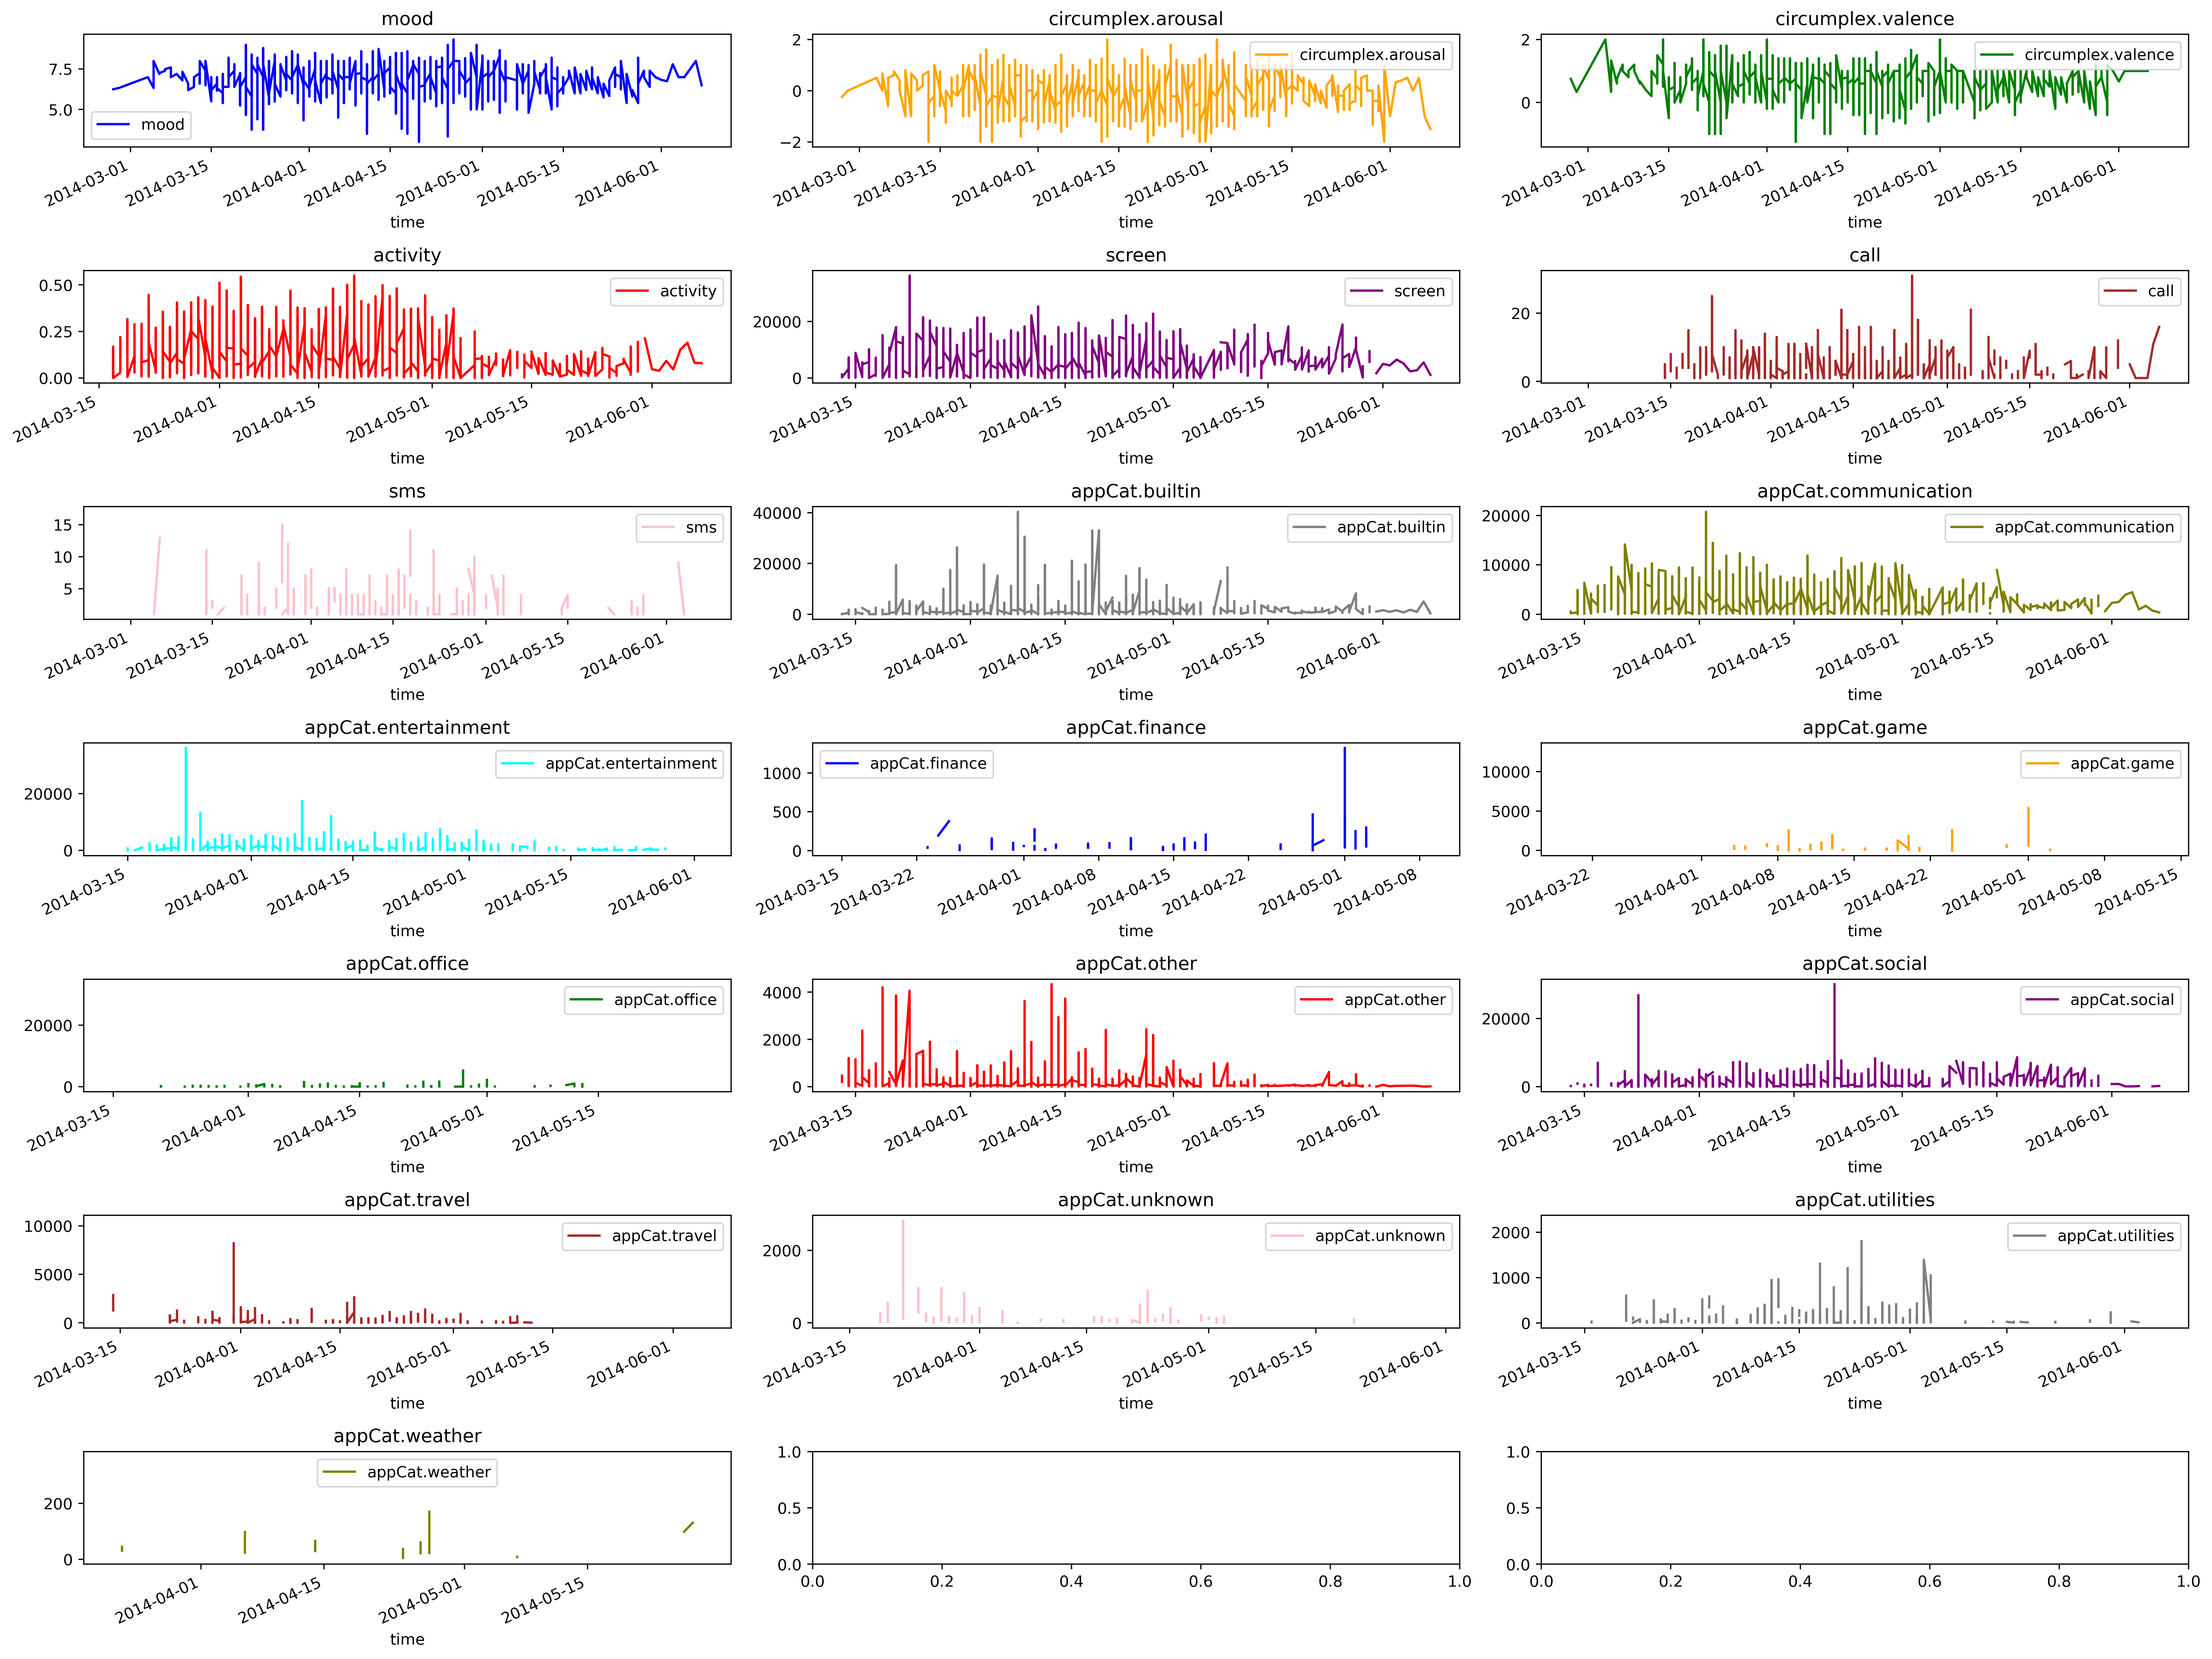

In [81]:
feature_keys = clean_data.columns[1:]

colors = [ "blue", "orange","green", "red","purple", "brown", "pink", "gray", "olive", "cyan"]

def show_raw_visualization(data):

    time_data = clean_data.index
    fig, axes = plt.subplots(
        nrows=7, ncols=3, figsize=(20, 15), dpi=400, facecolor="w", edgecolor="k")
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(ax=axes[i // 3, i % 3], color=c, title="{}".format(key), rot=25,)
        ax.legend([key])
    plt.tight_layout()


show_raw_visualization(clean_data)
plt.savefig('raw.png',dpi=600)

## Correlation matrix of all variables

In [65]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

Top Absolute Correlations
mood                  circumplex.valence      0.685227
screen                appCat.communication    0.667553
                      appCat.social           0.433550
appCat.office         appCat.weather          0.360483
screen                appCat.game             0.342348
activity              appCat.communication    0.249571
screen                appCat.entertainment    0.249142
activity              screen                  0.235538
appCat.game           appCat.weather          0.230535
appCat.communication  appCat.finance          0.210899
dtype: float64


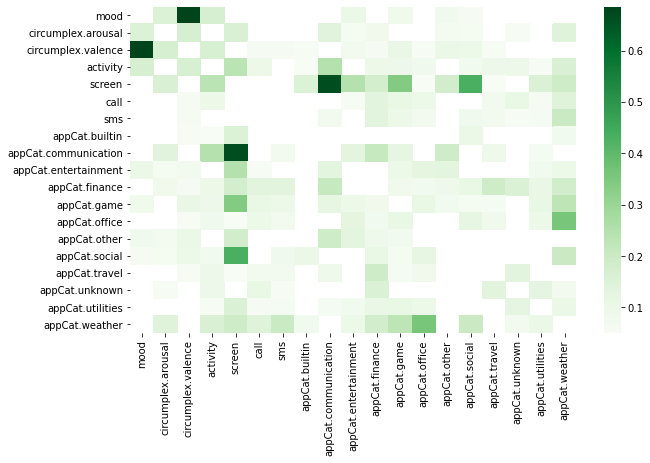

In [66]:
#print("I would suggest to drop 'Valence', 'Communication' and maybe some more attributes since they have very high correlations with other attributes.\n")

corr= clean_data.corr(min_periods=2).abs()
print("Top Absolute Correlations")
print(get_top_abs_correlations(clean_data.iloc[:,1:], 10))

kot = corr[(corr<1) & (corr>=0.05)]
plt.figure(figsize=(10,6))
corrmap= sns.heatmap(kot, cmap="Greens")

## Time series to supervised learning 


**Split the data before any preprocessing and imputing to avoid leakage from test set to the training set which may bias the predictions**

In [67]:
def split(df, train_frac = 0.7, rnd=0):
    d_copy = df.copy()
    d_copy['index_col'] = d_copy.index
    d_copy['dummy_idx'] = range(d_copy.shape[0])
    d_copy = d_copy.set_index('dummy_idx')

    train_df = d_copy.sample(frac= train_frac, random_state = rnd)
    test_df = d_copy.drop(train_df.index)
    train_df = train_df.set_index('index_col')
    test_df = test_df.set_index('index_col')
    
    return train_df, test_df

In [110]:
train_dataset, test_dataset = split(clean_data)
train_dataset

id      mood  circumplex.arousal  circumplex.valence  \
index_col                                                               
2014-03-31  AS14.23  7.500000           -0.250000            1.500000   
2014-04-13  AS14.08  7.600000            0.000000            1.200000   
2014-04-03  AS14.20  6.666667            0.333333            0.333333   
2014-03-24  AS14.01  6.000000            0.800000            0.000000   
2014-04-26  AS14.31  7.000000            0.333333            1.000000   
...             ...       ...                 ...                 ...   
2014-04-30  AS14.29  7.800000           -0.400000            0.200000   
2014-04-18  AS14.09  6.600000           -1.200000            0.600000   
2014-04-17  AS14.01  6.600000           -0.400000            0.600000   
2014-04-17  AS14.12  6.800000           -0.600000            0.800000   
2014-04-13  AS14.12  5.600000            0.600000            0.000000   

            activity        screen  call  sms  appCat.builtin  \
index_col                                                       
2014-03-31  0.383015  15913.595999   1.0  NaN        2354.496   
2014-04-13  0.004827   2078.960000   NaN  NaN           8.147   
2014-04-03  0.055023     54.653000   1.0  NaN          43.258   
2014-03-24  0.078961  15047.351001  10.0  NaN         866.956   
2014-04-26  0.480647   9394.792001  16.0  2.0        4263.613   
...              ...           ...   ...  ...             ...   
2014-04-30  0.091215   9185.733000   1.0  2.0        1098.170   
2014-04-18  0.114738   2364.162000   2.0  1.0         130.091   
2014-04-17  0.056918  15018.480001   2.0  NaN         552.201   
2014-04-17  0.131062   7747.719000   2.0  NaN        1108.736   
2014-04-13  0.095383   8651.996002   3.0  NaN        1239.178   

            appCat.communication  appCat.entertainment  appCat.finance  \
index_col                                                                
2014-03-31              8950.417              3680.247             NaN   
2014-04-13               658.403               221.563             NaN   
2014-04-03                   NaN                   NaN             NaN   
2014-03-24              9270.629               976.971          34.106   
2014-04-26              3626.216                56.575          85.333   
...                          ...                   ...             ...   
2014-04-30              3211.592               181.471             NaN   
2014-04-18               516.495              1488.692          80.219   
2014-04-17             11853.339               142.241             NaN   
2014-04-17              1762.530               434.020          49.768   
2014-04-13              1637.873              1137.717             NaN   

            appCat.game  appCat.office  appCat.other  appCat.social  \
index_col                                                             
2014-03-31      675.346            NaN        96.989        277.922   
2014-04-13          NaN            NaN       119.435       2874.220   
2014-04-03          NaN            NaN        11.387            NaN   
2014-03-24          NaN          3.010        66.558       3223.626   
2014-04-26          NaN          4.017       145.702        105.042   
...                 ...            ...           ...            ...   
2014-04-30          NaN        690.295        61.305       4138.987   
2014-04-18          NaN         72.352        12.053         38.117   
2014-04-17          NaN            NaN        53.763       2107.146   
2014-04-17          NaN        125.091        49.810       3914.188   
2014-04-13          NaN         45.218        70.062       4090.987   

            appCat.travel  appCat.unknown  appCat.utilities  appCat.weather  
index_col                                                                    
2014-03-31         34.179           7.025               NaN             NaN  
2014-04-13            NaN             NaN             5.043             NaN  
2014-04-03            

## Imputation techniques:

1) Below we try to find the best imputation techniques for SVR, RandomForest and GradientBoosting algorithms.

Note that the errors may be high because all the algorithms below run on default parameters which still need to be tuned for best results but doing this preliminary analysis gives a general idea about each impuatation technique for a given model.

In [69]:

def idx_sorter(df):
    df['col_index'] = df.index
    df['col_index'] = pd.to_datetime(df['col_index'])
    df = df.sort_values(by = ['id', 'col_index'], ascending = [True, True])
    df= df.drop(columns=['col_index'])
    return df


def impute_strat(df, zero=False, knn=False, mean=False, median=False, iterative=False): 
    temp_df = df.iloc[:,1:-1]
    cols = temp_df.columns
    target = df['target']
    ids = df['id']
    idx = df.index
    for i in cols:
        if temp_df[i].isnull().all():
            temp_df[i].fillna(0,inplace=True)
    
    if zero:
        imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
    elif knn:
        imputer = KNNImputer(missing_values=np.nan)
    elif mean:
        imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
    elif median:
        imputer = SimpleImputer(missing_values=np.nan, strategy="median")
    elif iterative:
        imputer = IterativeImputer(missing_values=np.nan, random_state=0, min_value=0,
                                   n_nearest_features=5,sample_posterior=True)
    else:
        print('Enter at least one strategy!!')
        return None

    if temp_df.shape[0]!=0:
        imputer.fit(temp_df)
        imp_df = imputer.transform(temp_df)
        imputed_df = pd.DataFrame(imp_df, columns = cols, index = idx)
        imputed_df.insert(loc=0, column='id', value = ids)
        imputed_df['target'] = target
        
        return imputed_df


def model_score(regressor, df, N_SPLITS=5):
    X = df.iloc[:,1:-1]
    y = df['target'] 
    score = cross_val_score(regressor, X, y, scoring='neg_mean_squared_error', cv=N_SPLITS)
    return score.mean(), score.std()


def preprocess(df, n=10, compare = False, impute = 'knn', test_set = False):
    assert impute in ['zero','knn','mean','median','iterative'], 'Should be zero, knn , mean , median or iterative'
    dict_zero = {};  dict_mean ={} ; dict_median = {}; dict_iter = {} ; dict_knn = {}
    for user_id in df['id'].unique():

        temp_d = df[df['id']== user_id] 
        temp_d = idx_sorter(temp_d)  
        temp_d['target']= temp_d['mood'].shift(-1)
        
        temp_d['prev_mood'] = temp_d['mood'].shift(1)

        #take rolling means for all cols except id and target, prev_day, and normalize columns
        for i in temp_d.columns[1:-2]:
            temp_d[i] = temp_d[i].rolling(n, min_periods=1).mean()
            temp_d[i] = preprocessing.minmax_scale(temp_d[i])

        # drop first (n-1) rows as instance cannnot be created before nth day
        temp_d = temp_d.drop(temp_d.index[:(n-1)])
        
        if temp_d.shape[0] != 0:
            # drop last row as n+1 datapoint unavailable 
            temp_d = temp_d.drop(temp_d.index[-1])
            
        prev_mood = temp_d['prev_mood']    
        temp_d = temp_d.drop(columns=['prev_mood'])
        if test_set and temp_d.shape[0]!=0:
            dict_zero[user_id] = impute_strat(temp_d, zero=True)
            dict_zero[user_id]['prev_mood'] = prev_mood
            dict_knn[user_id] = impute_strat(temp_d, knn=True)
            dict_knn[user_id]['prev_mood'] = prev_mood
            dict_mean[user_id] = impute_strat(temp_d, mean=True)
            dict_mean[user_id]['prev_mood'] = prev_mood
            dict_median[user_id] = impute_strat(temp_d, median=True)
            dict_median[user_id]['prev_mood'] = prev_mood
            dict_iter[user_id] = impute_strat(temp_d, iterative=True)
            dict_iter[user_id]['prev_mood'] = prev_mood
        else:
            dict_zero[user_id] = impute_strat(temp_d, zero=True)
            dict_knn[user_id] = impute_strat(temp_d, knn=True)
            dict_mean[user_id] = impute_strat(temp_d, mean=True)
            dict_median[user_id] = impute_strat(temp_d, median=True)
            dict_iter[user_id] = impute_strat(temp_d, iterative=True)

    df_zero = idx_sorter(pd.concat(dict_zero.values()))
    df_knn = idx_sorter(pd.concat(dict_knn.values()))
    df_mean = idx_sorter(pd.concat(dict_mean.values()))
    df_median = idx_sorter(pd.concat(dict_median.values()))
    df_iter = idx_sorter(pd.concat(dict_iter.values()))
    
    return_dict = {'zero':df_zero, 'knn':df_knn, 'mean':df_mean,'median':df_median,'iterative':df_iter }

    if compare:
        regressor_dict = {'SVM':svm.SVR(),'RandomForest':RandomForestRegressor(random_state=0), 
                          'GradientBoost': GradientBoostingRegressor(random_state=0) }
        
        mse = {'SVM':np.zeros(5),'RandomForest':np.zeros(5),'GradientBoost':np.zeros(5)}
        std = {'SVM':np.zeros(5),'RandomForest':np.zeros(5),'GradientBoost':np.zeros(5)}
        
        x_labels = ['Zero imputation', 'KNN Imputation', 'Mean Imputation', 'Median Imputation','Iterative Imputation']
        for j in regressor_dict:
            mse[j][0], std[j][0] = model_score(regressor_dict[j], df_zero)
            mse[j][1], std[j][1] = model_score(regressor_dict[j], df_knn)
            mse[j][2], std[j][2] = model_score(regressor_dict[j], df_mean)
            mse[j][3], std[j][3] = model_score(regressor_dict[j], df_median)
            mse[j][4], std[j][4] = model_score(regressor_dict[j], df_iter)
            
        for i in mse:
            n_bars = len(mse[i])
            xval = np.arange(n_bars)

            colors = ['r', 'g', 'b', 'orange', 'black']

            plt.figure(figsize=(12, 5))
            ax = plt.subplot()
            for j in xval:
                ax.barh(j, mse[i][j], xerr=std[i][j], color=colors[j], alpha=0.6, align='center')

            ax.set_title('Imputation Techniques with {}'.format(i))
            ax.set_xlim(left=np.min(mse[i]) * 0.4, right=np.max(mse[i]) * 1.6)
            ax.set_yticks(xval)
            ax.set_xlabel('MSE')
            ax.invert_yaxis()
            ax.set_yticklabels(x_labels)
            plt.grid()
            plt.show()
            
        #plt.savefig('impute.png', dpi = 600)    
        return None
    
    else:
        return return_dict[impute]

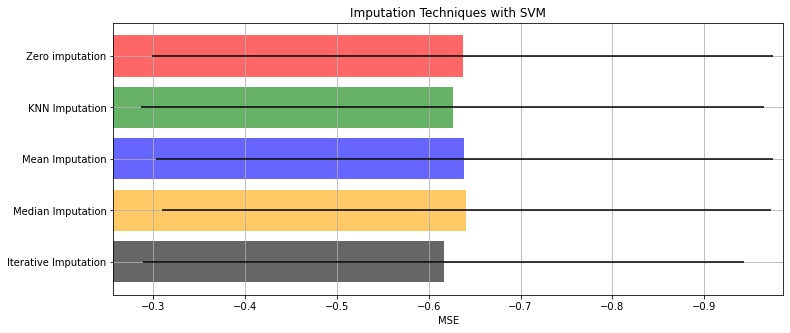

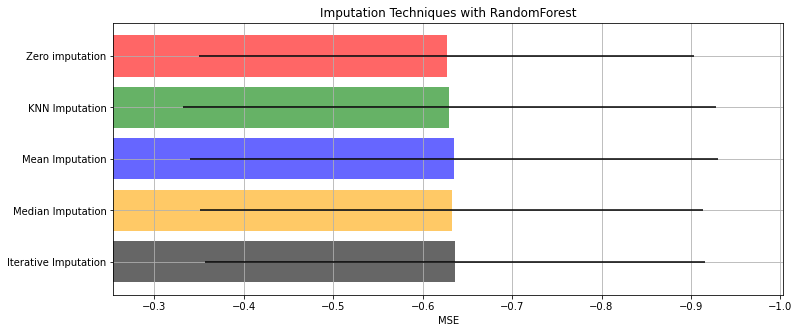

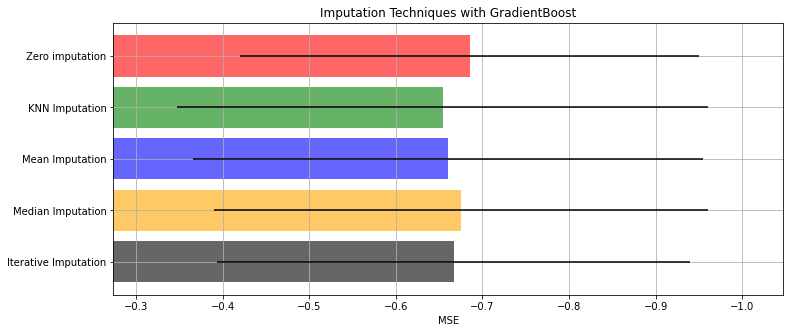

In [70]:
'''Compare different Imputation strategies'''

preprocess(train_dataset,compare=True)

In [118]:
'''Preprocess train and test dataset with an optimal startegy'''
train_data_proc = preprocess(train_dataset,impute='knn')
test_data_proc = preprocess(test_dataset, impute='knn', test_set=True)

X_train = train_data_proc.iloc[:,1:-1]
y_train = train_data_proc['target']
X_test = test_data_proc.iloc[:,1:-2]
y_test = test_data_proc['target']
y_bench = test_data_proc['prev_mood']

## Evaluation setup 

We use the Repeated Holdout Validation or Monte Carlo Cross Validation to choose our model. The main principle here is we split the data into training and test sets 'k' times with different random seeds and compute the average performance over these k repetitions. We use MSE as a performance indicator here.

Paper: Raschka, S., 2018. Model evaluation, model selection, and algorithm selection in machine learning. arXiv preprint arXiv:1811.12808.

In [83]:
def evaluation_setup(data, sims=100):
    regressor_dict = {'SVM':svm.SVR(),'RandomForest':RandomForestRegressor(n_jobs=-1), 'GradientBoost': GradientBoostingRegressor() }
    mse_true = {i:[] for i in regressor_dict}
    mse_bench = {i:[] for i in regressor_dict}

    for reg in regressor_dict:
        for i in tqdm(range(sims)):
            train_df , test_df = split(data, train_frac = 0.7, rnd=i)
            train_proc = preprocess(train_df, n=10, impute = 'knn', test_set = False)
            test_proc = preprocess(test_df, n=10, impute = 'knn', test_set = True)
            X_tr = train_proc.iloc[:,1:-1]
            y_tr = train_proc['target']
            X_t = test_proc.iloc[:,1:-2]
            y_t = test_proc['target']
            y_b = test_proc['prev_mood']
            regressor_dict[reg].fit(X_tr, y_tr)
            predictions = regressor_dict[reg].predict(X_t)
            mse_true[reg].append(mean_squared_error(y_t, predictions))
            mse_bench[reg].append(mean_squared_error(y_b, predictions))

    return mse_true,  mse_bench

mse_true, mse_bench = evaluation_setup(clean_data, sims=100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [23:28<00:00, 14.09s/it]



 for SVM 
 benchmark conf interval=[0.5615115363507934, 0.6113796666982501] model conf intreval=[0.5561924766279349, 0.6047940211104295]

 for RandomForest 
 benchmark conf interval=[0.5548603139891464, 0.599197566716142] model conf intreval=[0.5603490187304967, 0.6043257242262594]

 for GradientBoost 
 benchmark conf interval=[0.5982470789374734, 0.6453484164684284] model conf intreval=[0.5895454413386636, 0.6375061231120407]


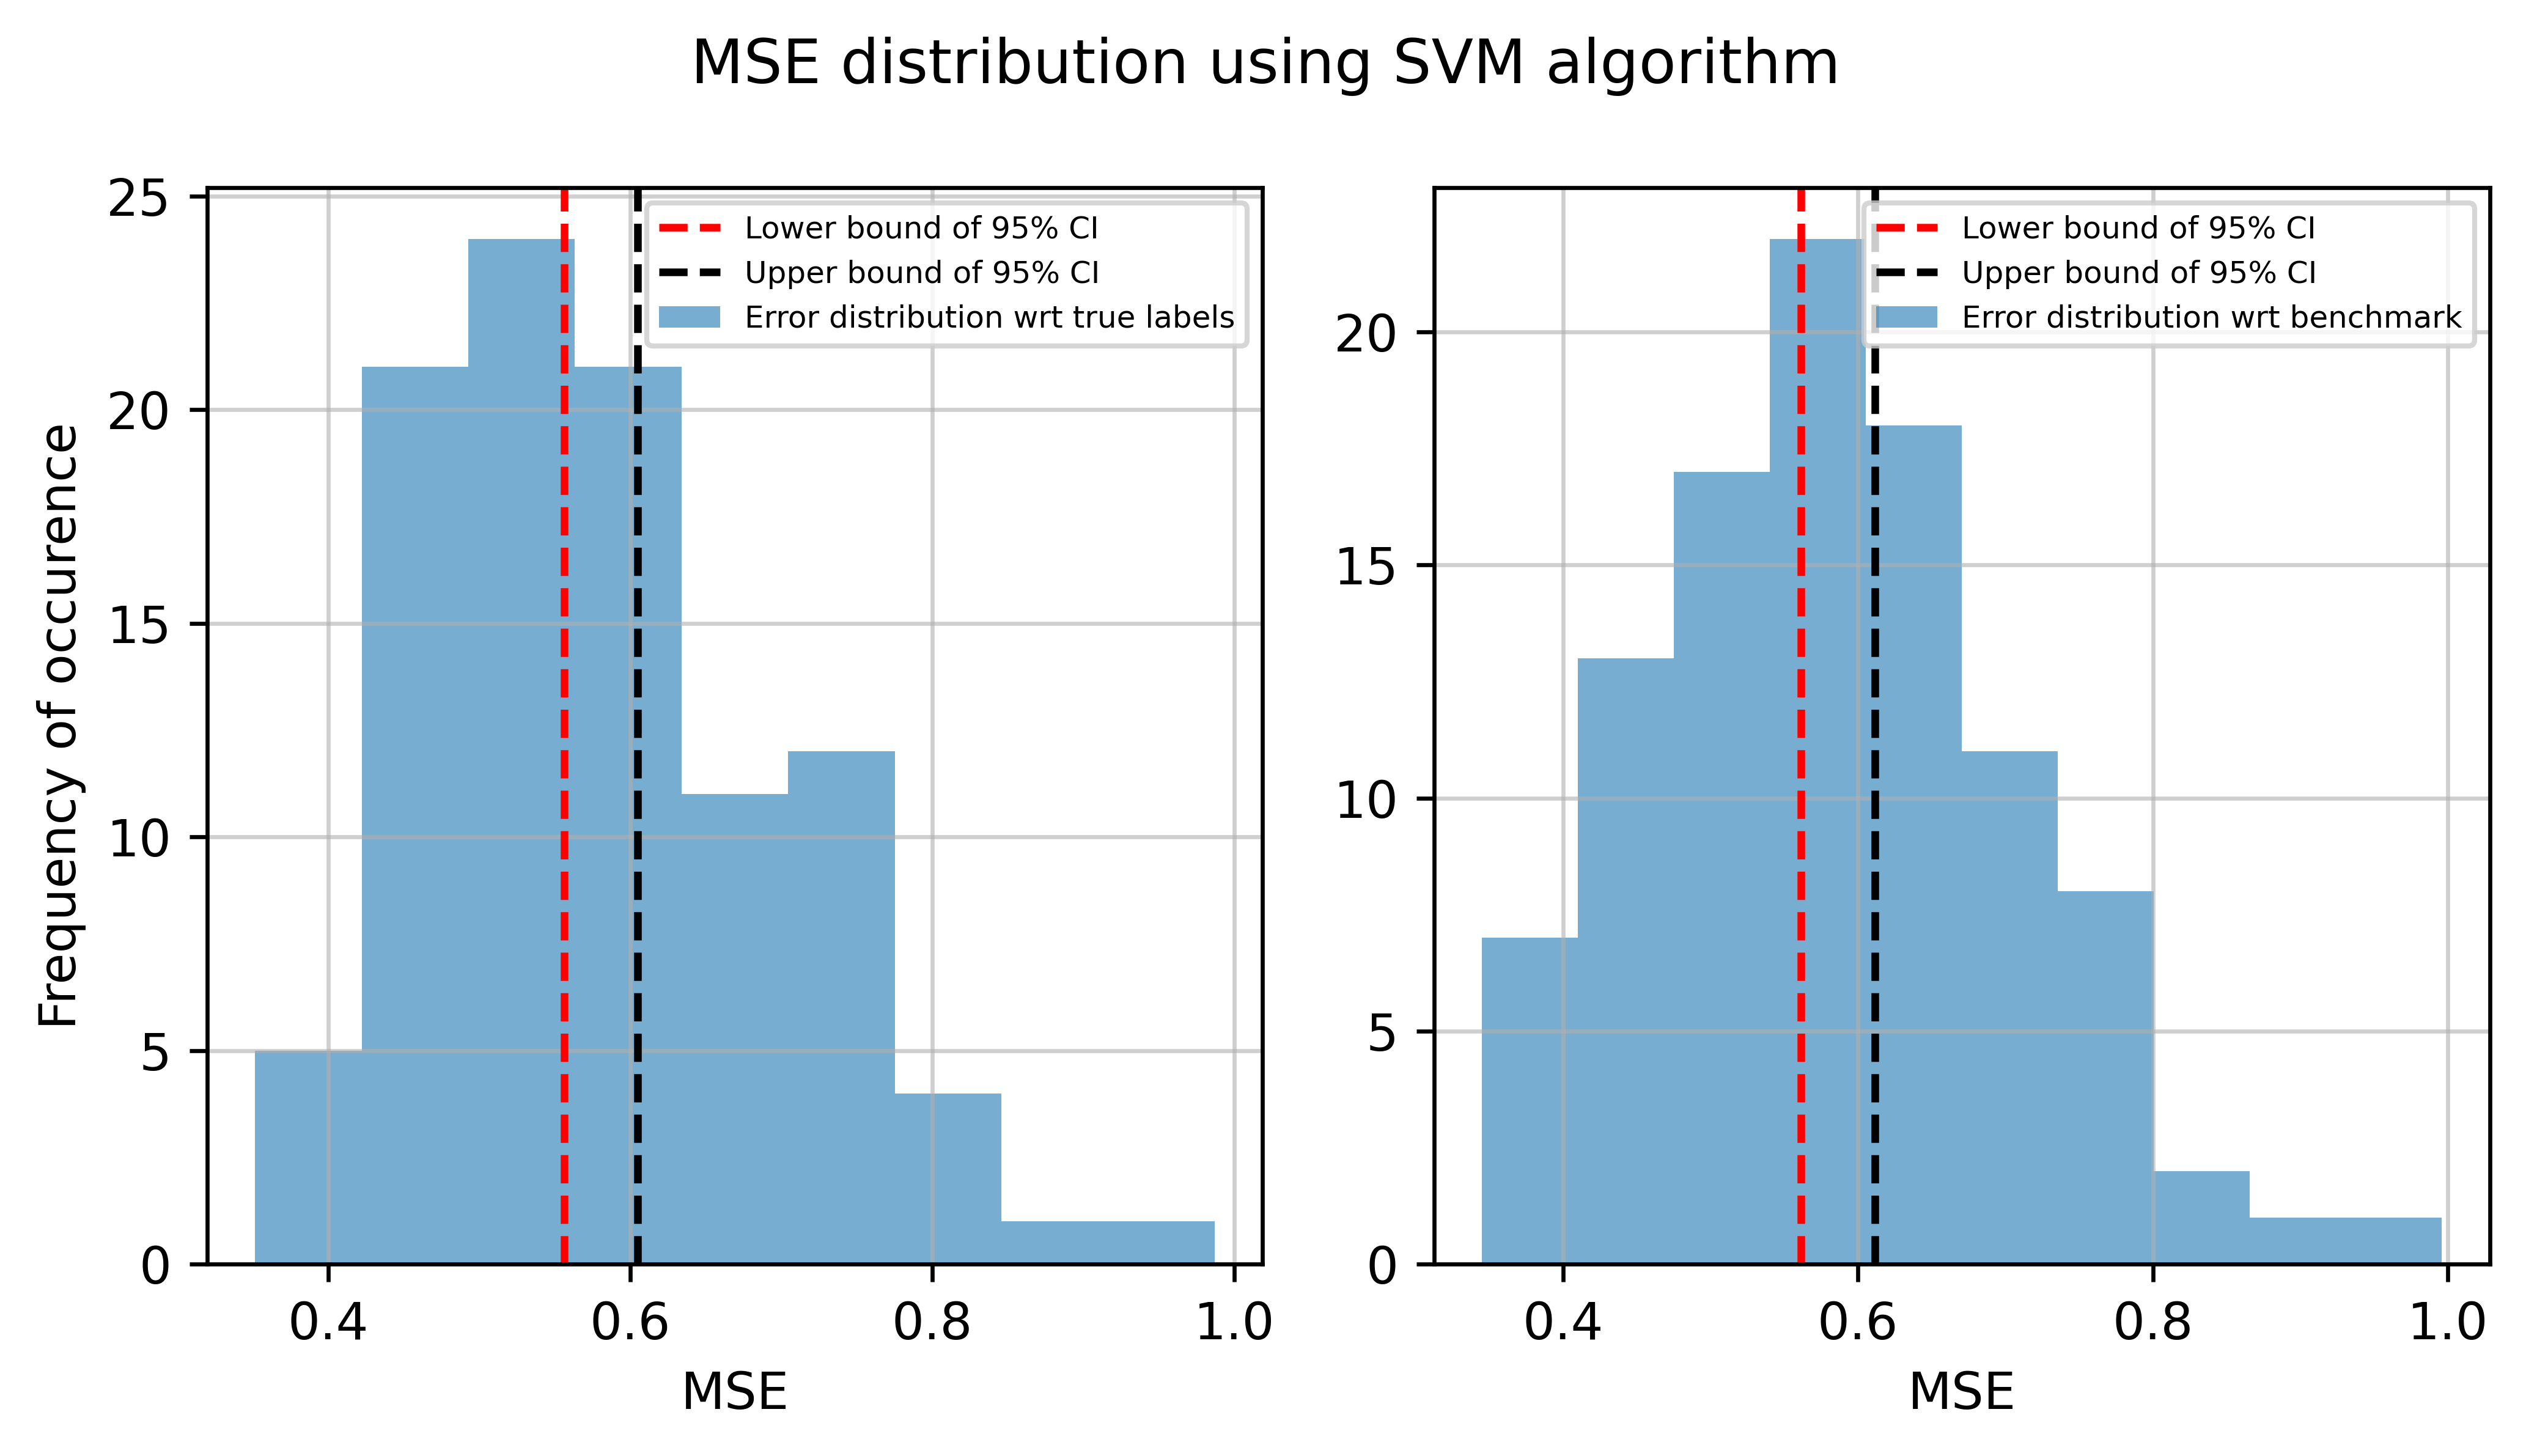

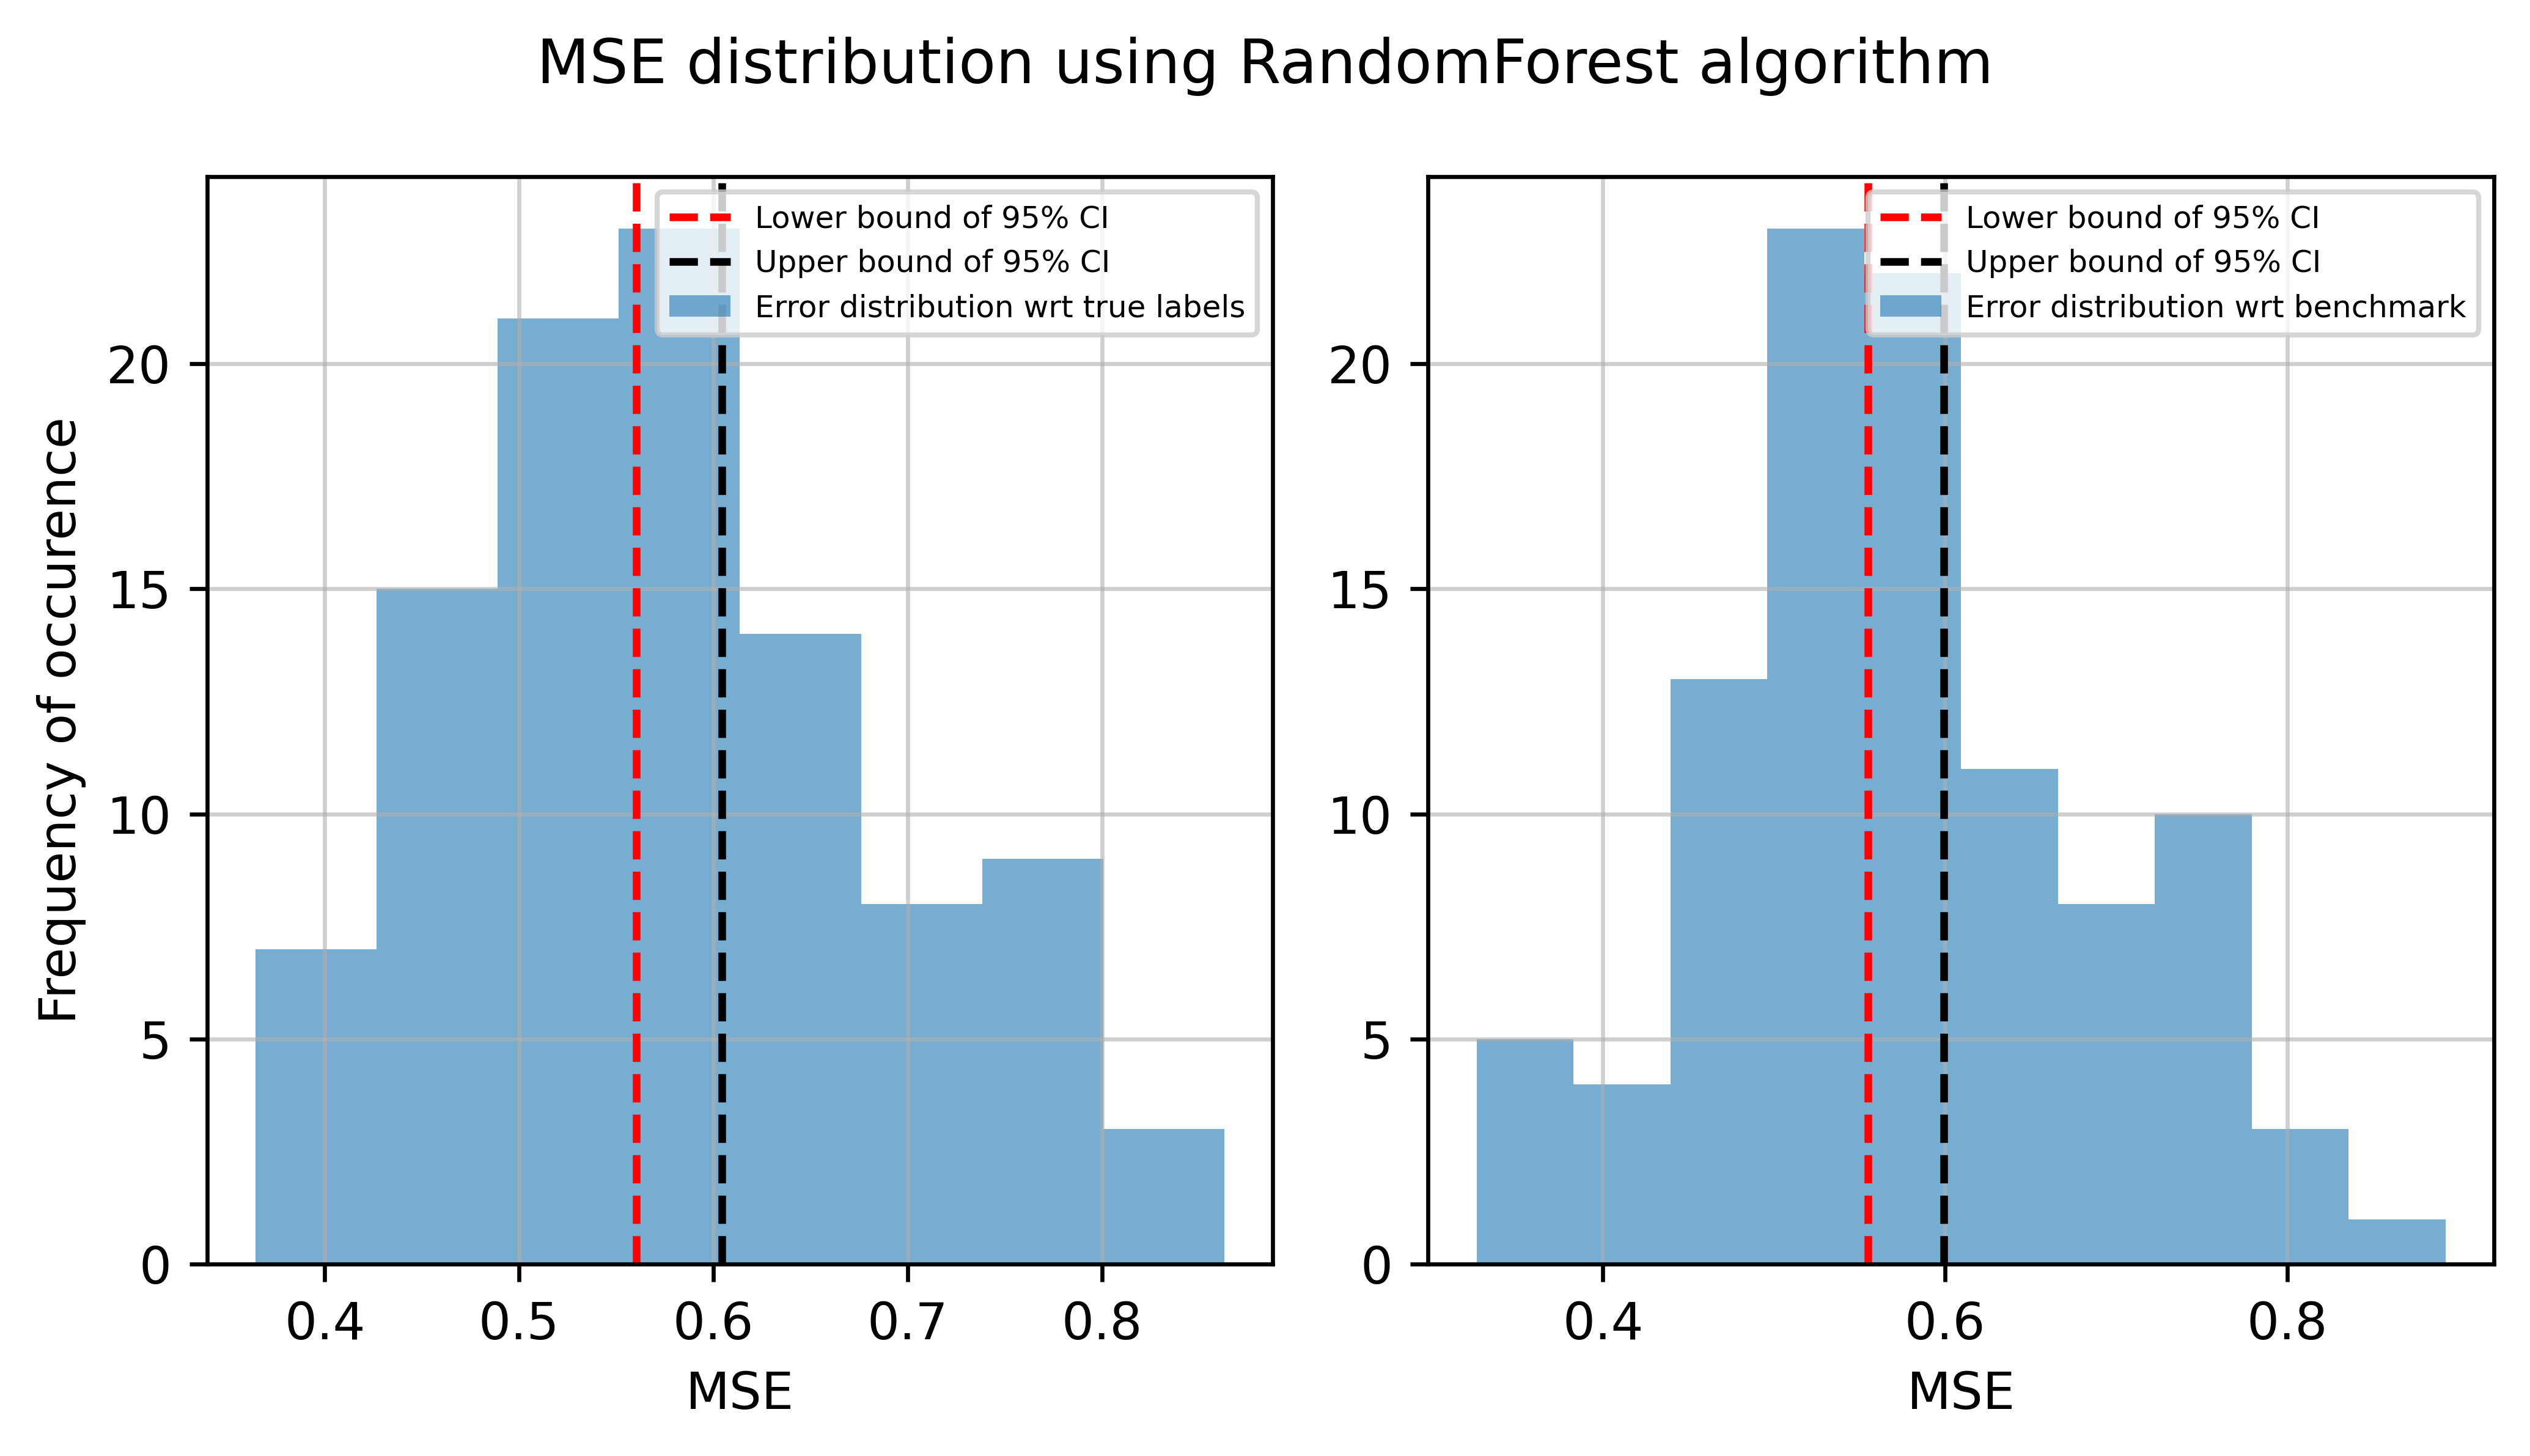

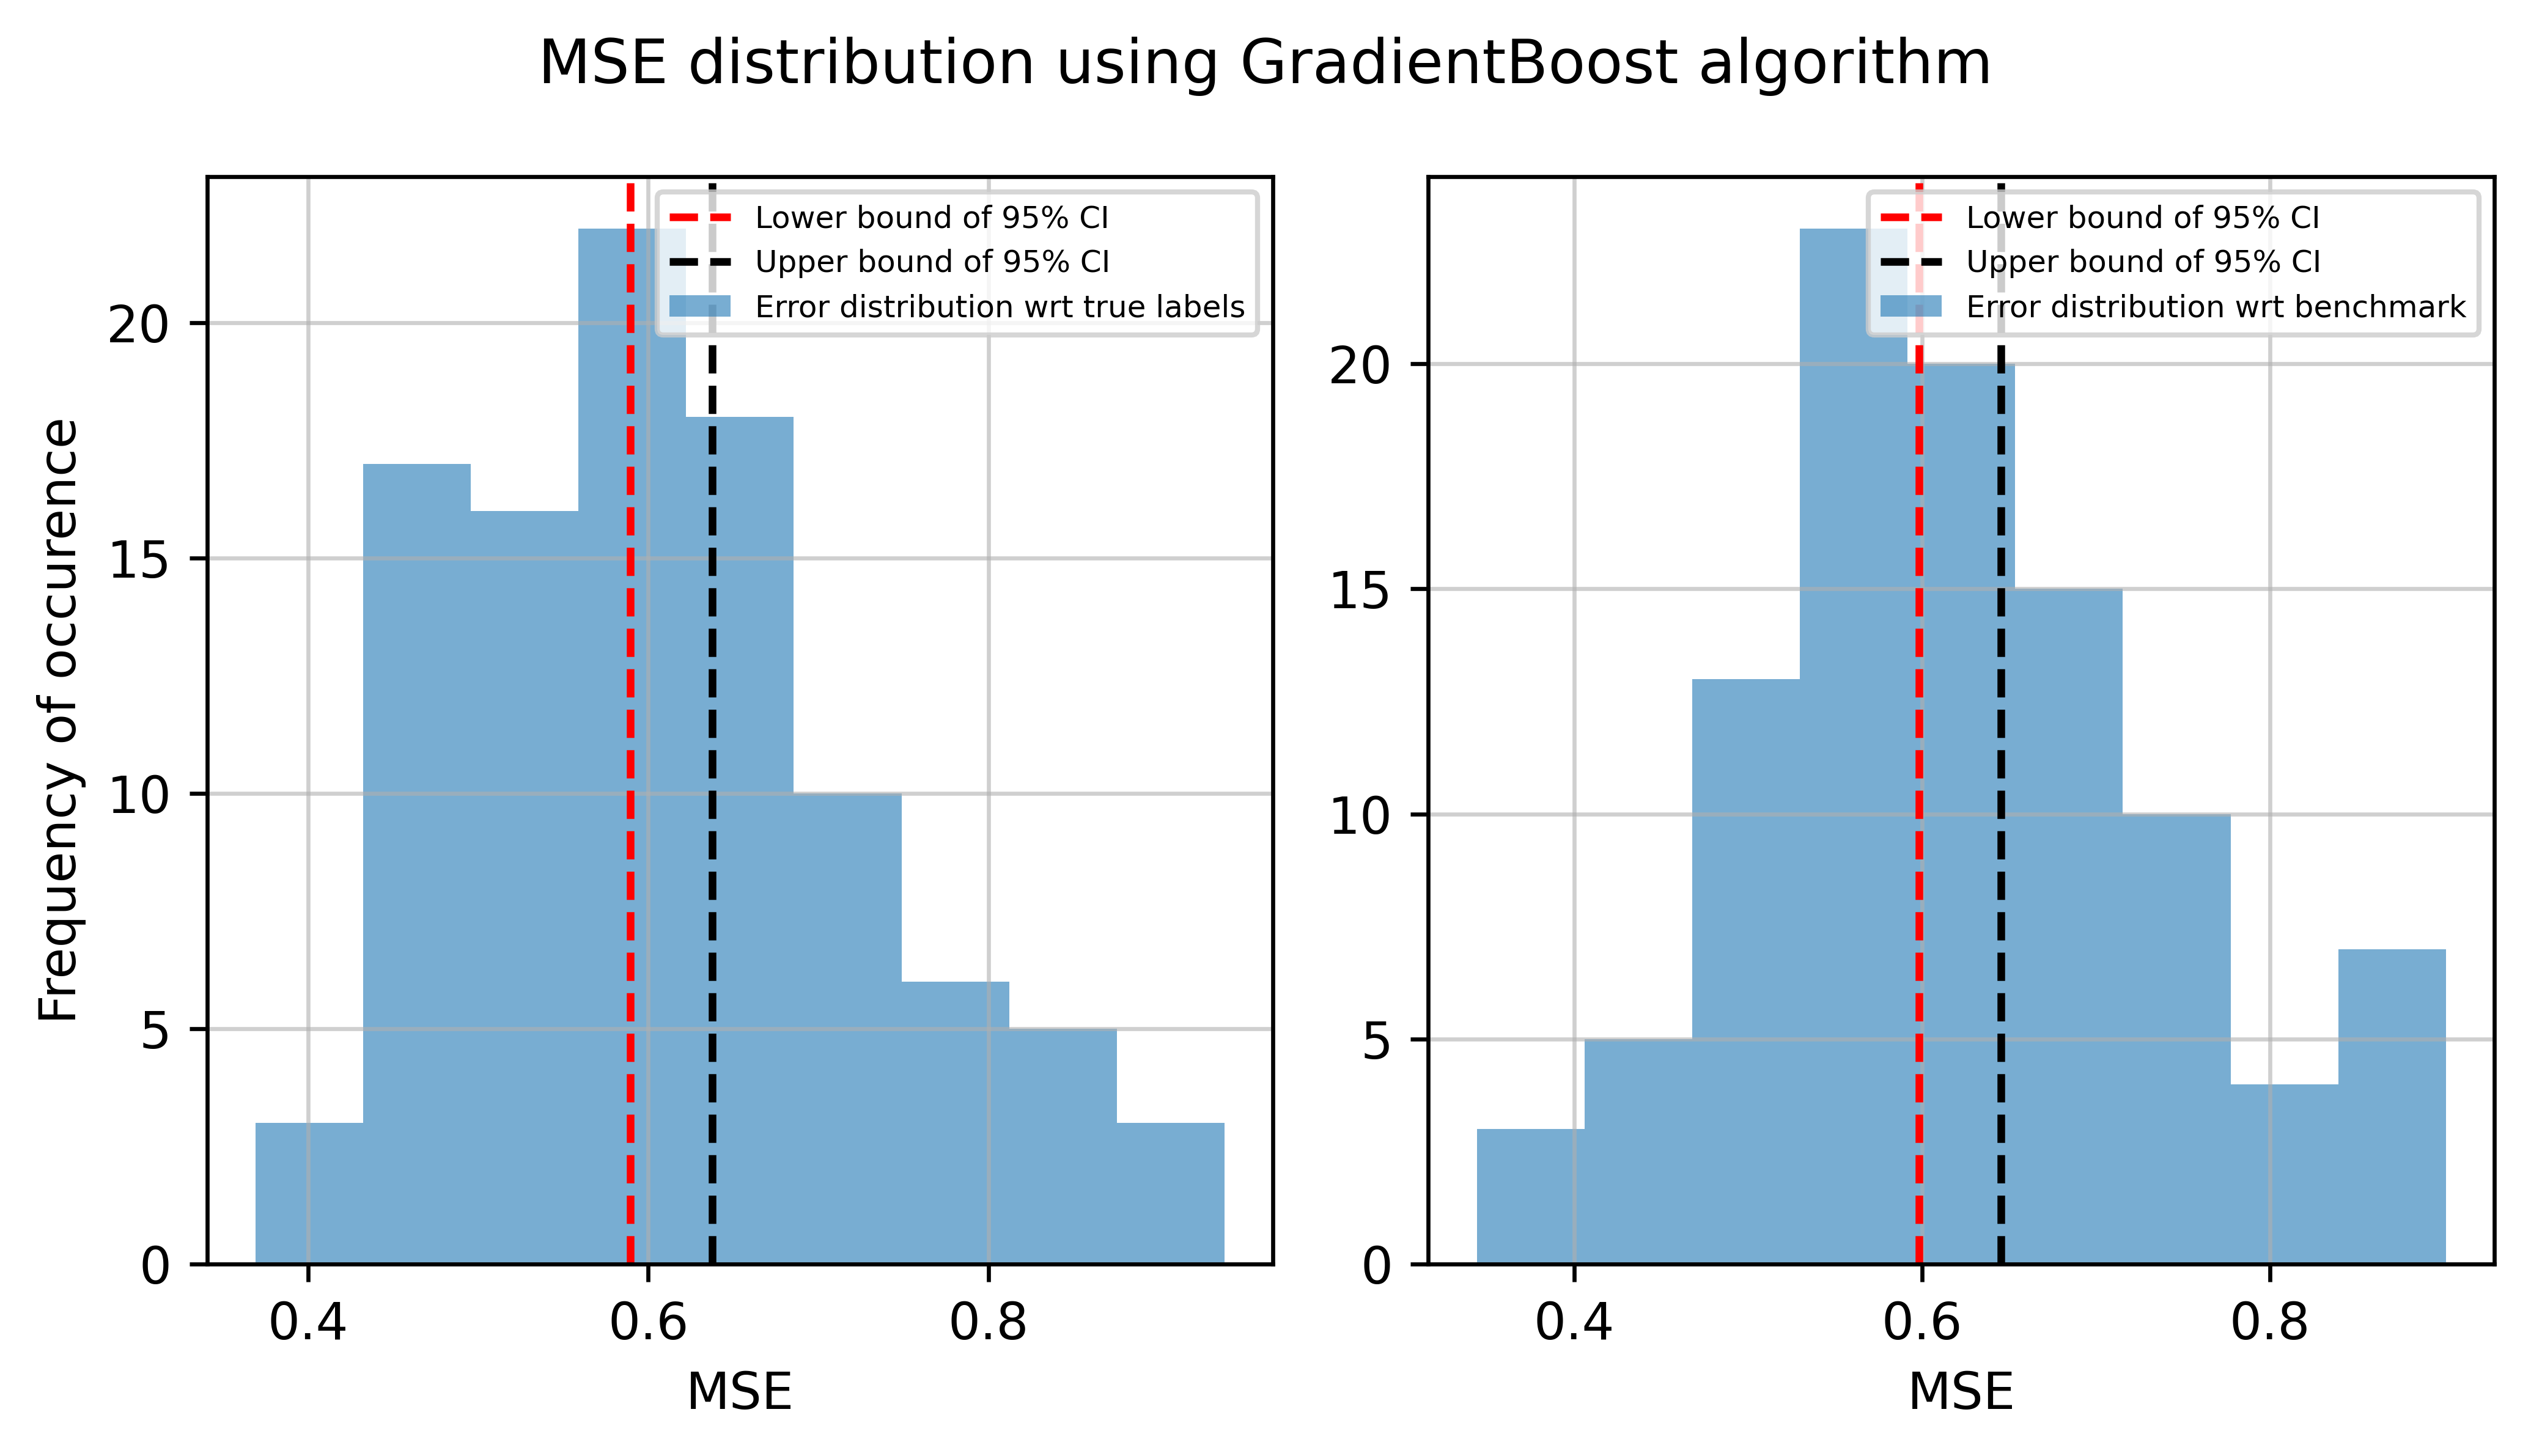

In [127]:
# Plot the histograms.
regressor_dict = {'SVM':svm.SVR(),'RandomForest':RandomForestRegressor(n_jobs=-1), 'GradientBoost': GradientBoostingRegressor() }
for reg in regressor_dict:
    #compute 95% conf intervals 
    lb_true, ub_true = st.t.interval(0.95, len(mse_true[reg])-1, loc=np.mean(mse_true[reg]), scale=st.sem(mse_true[reg]))
    lb_bench, ub_bench = st.t.interval(0.95, len(mse_bench[reg])-1, loc=np.mean(mse_bench[reg]), scale=st.sem(mse_bench[reg]))
    fig = plt.figure(figsize=(7,4), dpi = 600)
    plt.suptitle('MSE distribution using {} algorithm'.format(reg))
    plt.subplot(1,2,1)
    plt.hist(mse_true[reg], bins= "auto", alpha=0.6, label="Error distribution wrt true labels")
    plt.axvline(x = lb_true, color='r', linestyle='--', label='Lower bound of 95% CI')
    plt.axvline(x = ub_true, color='k', linestyle='--', label='Upper bound of 95% CI')
    plt.xlabel('MSE')
    plt.ylabel('Frequency of occurence')
    plt.grid(alpha=0.6)
    plt.legend(fontsize=6)
    plt.subplot(1,2,2)
    plt.hist(mse_bench[reg], bins= "auto", alpha=0.6, label="Error distribution wrt benchmark")
    plt.axvline(x = lb_bench, color='r', linestyle='--', label='Lower bound of 95% CI')
    plt.axvline(x = ub_bench, color='k', linestyle='--', label='Upper bound of 95% CI')
    plt.xlabel('MSE')
    plt.grid(alpha=0.6)
    plt.legend(fontsize= 6)
    plt.tight_layout()
    print('\n','for {}'.format(reg), '\n','benchmark conf interval={}'.format([lb_bench, ub_bench]),
          'model conf intreval={}'.format([lb_true, ub_true]))
    #plt.savefig('err_dist{}.png'.format(reg), dpi = 600) 


In [86]:
learn_data = preprocess(clean_data)

### Learning curve
A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

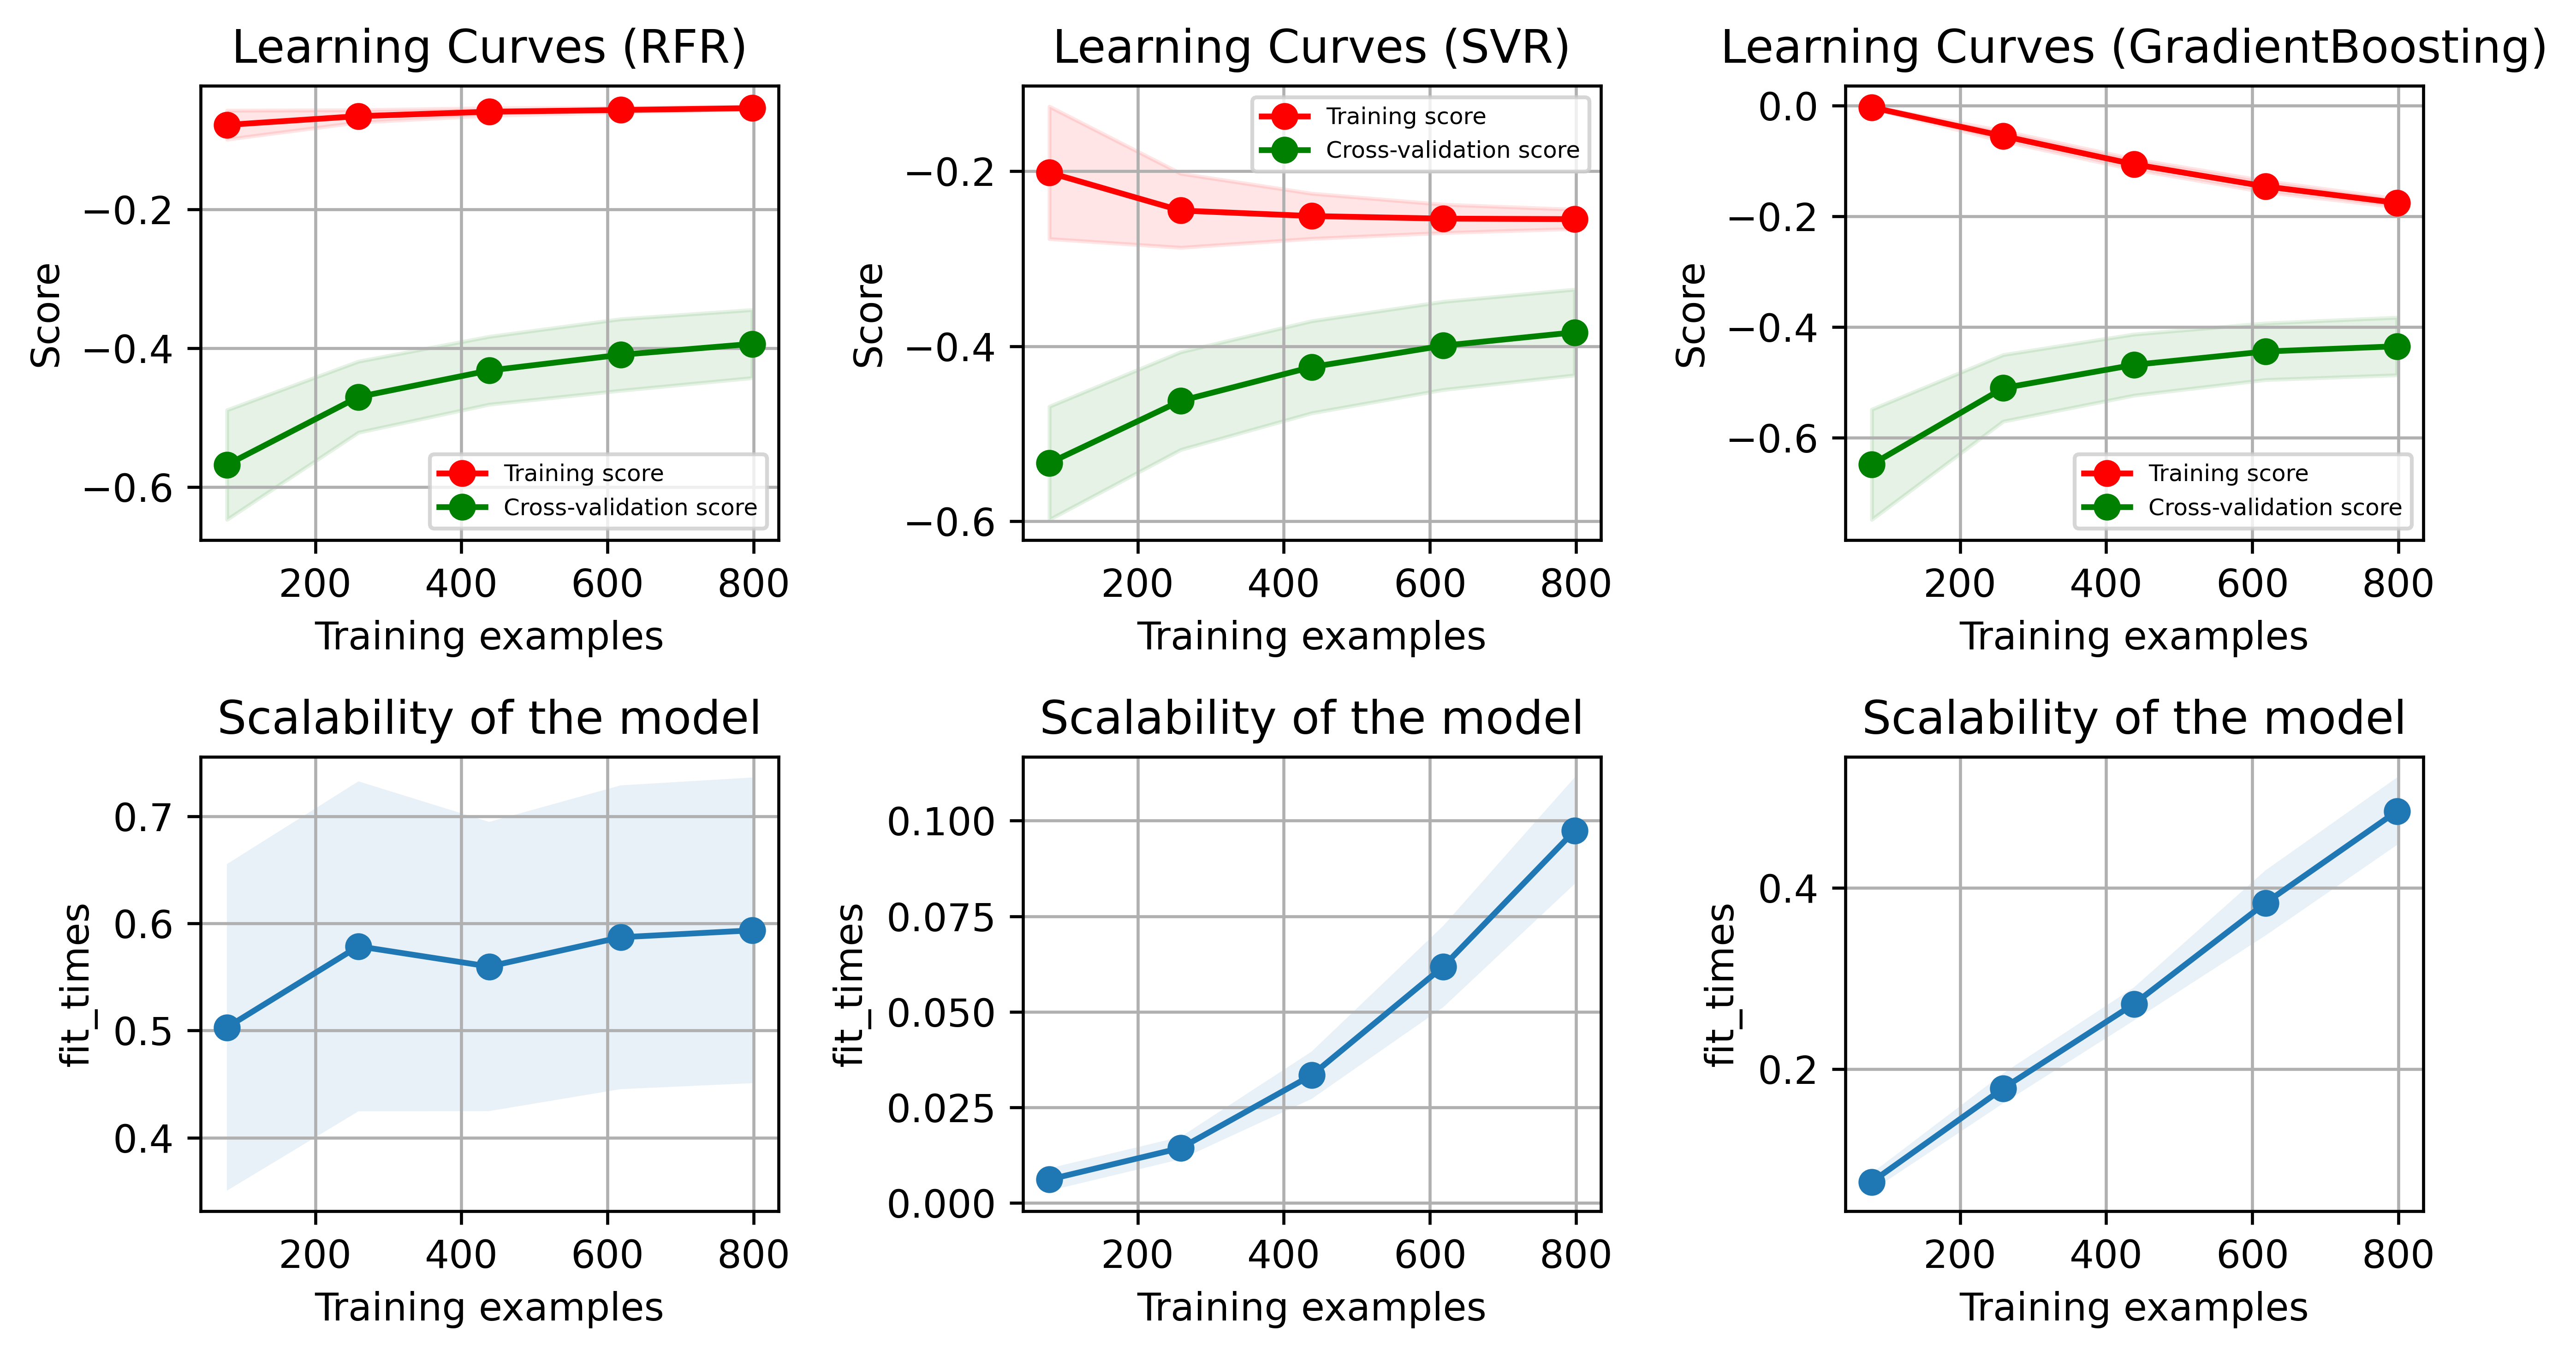

In [95]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, 
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
                       scoring = 'neg_mean_squared_error',return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best",fontsize=6)

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    plt.tight_layout()

    return plt


fig, axes = plt.subplots(2, 3, figsize=(9, 5), dpi=600)

X = learn_data.iloc[:,1:-1]
y = learn_data['target']

title = "Learning Curves (RFR)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestRegressor(n_jobs=-1)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], cv=cv, n_jobs=-1)

title = r"Learning Curves (SVR)"

estimator = svm.SVR()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], cv=cv, n_jobs=-1)

title = r"Learning Curves (GradientBoost)"
estimator = GradientBoostingRegressor()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 2], cv=cv, n_jobs=-1)

#plt.show()
plt.savefig('learning_curve.png', dpi = 600) 

## Feature Selection

Now, we try to find the best attributes to include in our model using 4 different techniques.

a) *Univariate Feature Selection using mutual information*- This is kind of a raw estimation to see interdependencies between the attributes and target. However, I prefer not using it given the high dimensionality of our problem.

b) *SFS* - Though slower than rest of the feature selction techniques, I suggest using the Sequential Feature Selection (SFS) because it cross-validates many different models for each of the iterations. Secondly, SFS works with any model, while Tree Based and RFE require the underlying estimator to have a 'coef_' attribute or a 'feature_importances_' attribute.

c) *RFE* - This one is really useful in determining the optimal number of features to use. 

d) *Tree Based Feature Selection* - is specific to tree based algorithms using feature_importances. A more general approach is to use the permutation_importances with them. 

**I would suggest :** 
1) Use RFE to determine the optimal no. of features 

2) Use SFS with param 'n_features_to_select' set to the no. of features from step 1. Compare step 1 and 2 to find the best features to keep.

3) Then use Tree based feature selection(using permutation importance) to compare with features obtained from step 2. 

**Obviously, this is not the only way we can do feature selection. In the end, its all about tradeoffs.** 

### Univariate Feature selection using Mutual Information 
Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. 

More about this on : https://en.wikipedia.org/wiki/Mutual_information

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#r37d39d7589e2-1

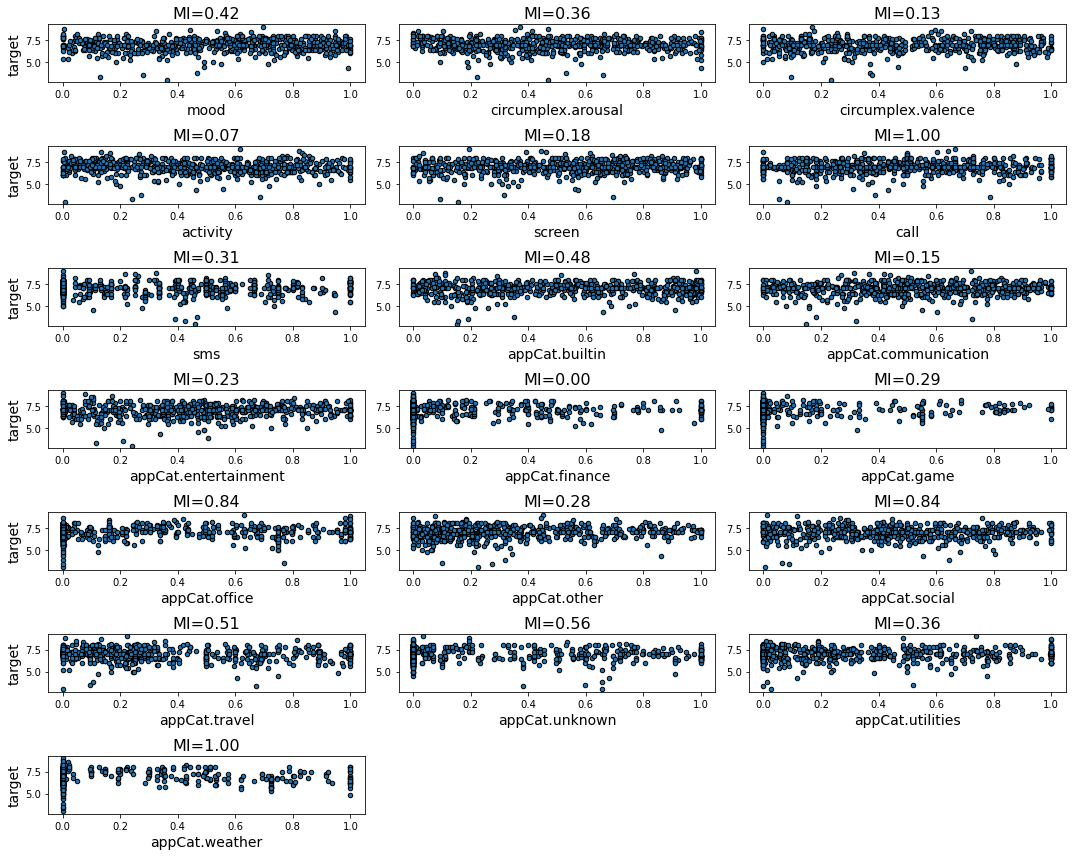

In [73]:
#np.random.seed(0)

mi = mutual_info_regression(X_train, y_train, discrete_features=False)
mi /= np.max(mi)

plt.figure(figsize=(15, 12))
for i in range(X_train.shape[1]):
    plt.subplot(7, 3, i + 1)
    plt.scatter(X_train.iloc[:, i], y_train, edgecolor='black', s=20)
    plt.xlabel("{}".format(X_train.iloc[:, i].name), fontsize=14)
    if i%3== 0:
        plt.ylabel("target", fontsize=14)
    plt.title("MI={:.2f}".format(mi[i]), fontsize=16)
plt.tight_layout()
plt.show()
#plt.savefig('mutual_info.png', dpi = 600)

### Recursive Feature elimination  with cross validation (RFECV)

This requires the estimator to assign weights to the features, for eg feature importances or coefficients. 

Recursive feature elimination (RFE) selects features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute (such as coef_, feature_importances_). Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Below we do RFE in a cross-validation loop which basically does an automatic tuning of the number of features based on scoring function.

More on it on: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [112]:
#Estimator = RandomForestRegressor(max_depth=400, n_estimators=1000, random_state=0)
Estimator = svm.SVR()

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=Estimator, step=1, cv=5, n_jobs=-1,scoring='neg_mean_squared_error', min_features_to_select=min_features_to_select)

rfecv = rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print("Features selected : "f"{X_train.columns[rfecv.support_].tolist()}")

# Plot number of features VS. cross-validation scores
plt.figure(dpi=400)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (MSE)")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
plt.show()
#fig.savefig('rfecv.png', dpi = 600)

ValueError: when `importance_getter=='auto'`, the underlying estimator SVR should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

### Sequential Feature Selection(SFS)

SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. This can done either in a forward and backward manner. In a forward SFS we start with zero feature and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the $\text{n_features_to_select}$ parameter.

Backward-SFS follows the same idea but works in the opposite direction: instead of starting with no feature and greedily adding features, we start with all the features and greedily remove features from the set. 

Paper about this- http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.24.4369&rep=rep1&type=pdf

In [99]:
#Estimator = RandomForestRegressor(max_depth=400, n_estimators=1000)
#Estimator = RandomForestRegressor(random_state=0)
Estimator = svm.SVR()

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(Estimator, n_features_to_select=12, n_jobs=-1, direction='forward').fit(X_train, y_train)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(Estimator, n_features_to_select=12, n_jobs=-1, direction='backward').fit(X_train, y_train)
toc_bwd = time()

print("Features selected by forward sequential selection: "f"{X_train.columns[sfs_forward.get_support()].tolist()}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print("Features selected by backward sequential selection: "f"{X_train.columns[sfs_backward.get_support()].tolist()}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by forward sequential selection: ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'call', 'sms', 'appCat.finance', 'appCat.office', 'appCat.social', 'appCat.utilities', 'appCat.weather']
Done in 4.576s
Features selected by backward sequential selection: ['circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'sms', 'appCat.builtin', 'appCat.finance', 'appCat.office', 'appCat.social', 'appCat.travel', 'appCat.utilities', 'appCat.weather']
Done in 3.497s


### Tree Based Feature Selection

Tree-based models assign weights to the features using feature importances based on the mean decrease in impurity (MDI). Impurity is quantified by the splitting criterion of the decision trees (Gini, Entropy or Mean Squared Error). However, this method can give high importance to features that may not be predictive on unseen data when the model is overfitting. Permutation-based feature importance, on the other hand, avoids this issue, since it can be computed on unseen data. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories. **(We do have quite a few app.times which are mostly zero hence including permutation importance makes sense here )**

Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may be computed performance metric on the model predictions predictions and can be used to analyze any model class (not just tree-based models).

More about this:  https://scikit-learn.org/stable/modules/permutation_importance.html#id2

Paper:  L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001. https://doi.org/10.1023/A:1010933404324

<ipython-input-36-2af3a26142a9>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


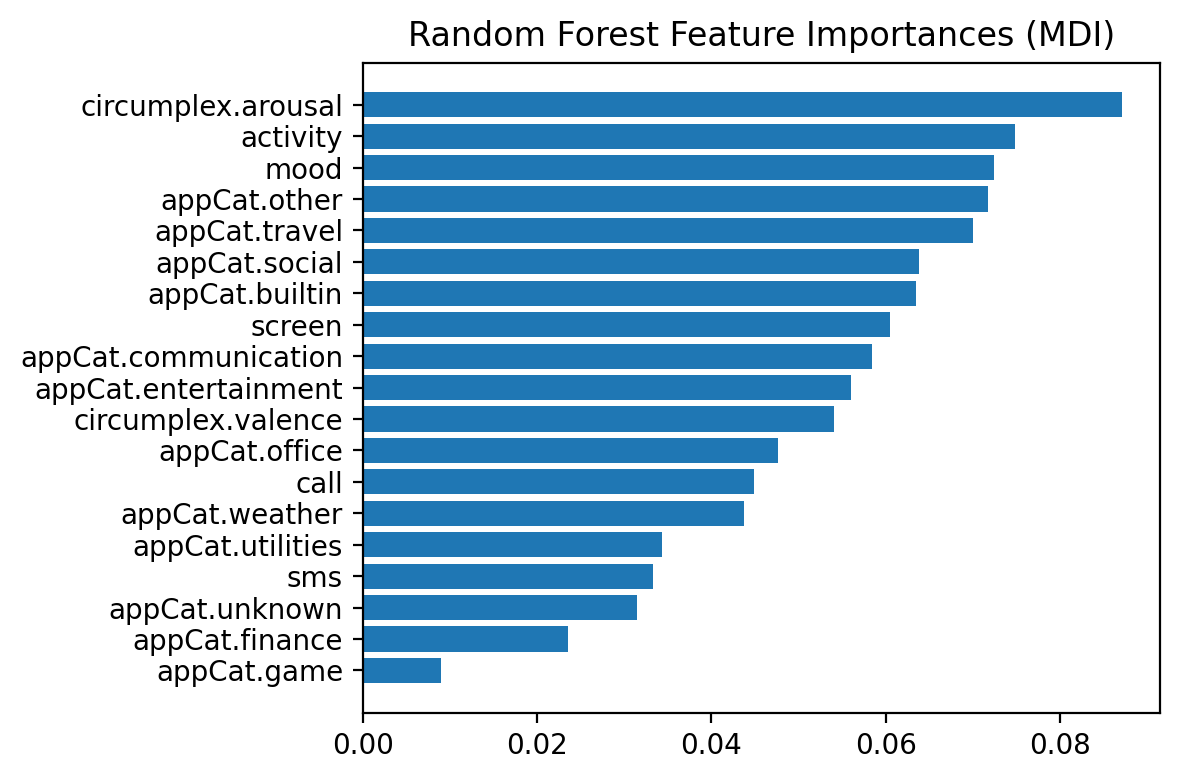

In [36]:
forest = RandomForestRegressor(max_depth=400, n_estimators=1000, random_state=0)
forest.fit(X_train, y_train)

tree_feature_importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
#indices = np.argsort(importances)[::-1]

feature_names = X_train.columns.values #np.r_[feature_names, numerical_columns]

#tree_feature_importances = ( rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort().tolist()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(dpi=200)
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()
#fig.savefig('rfr_importance.png', dpi = 200)

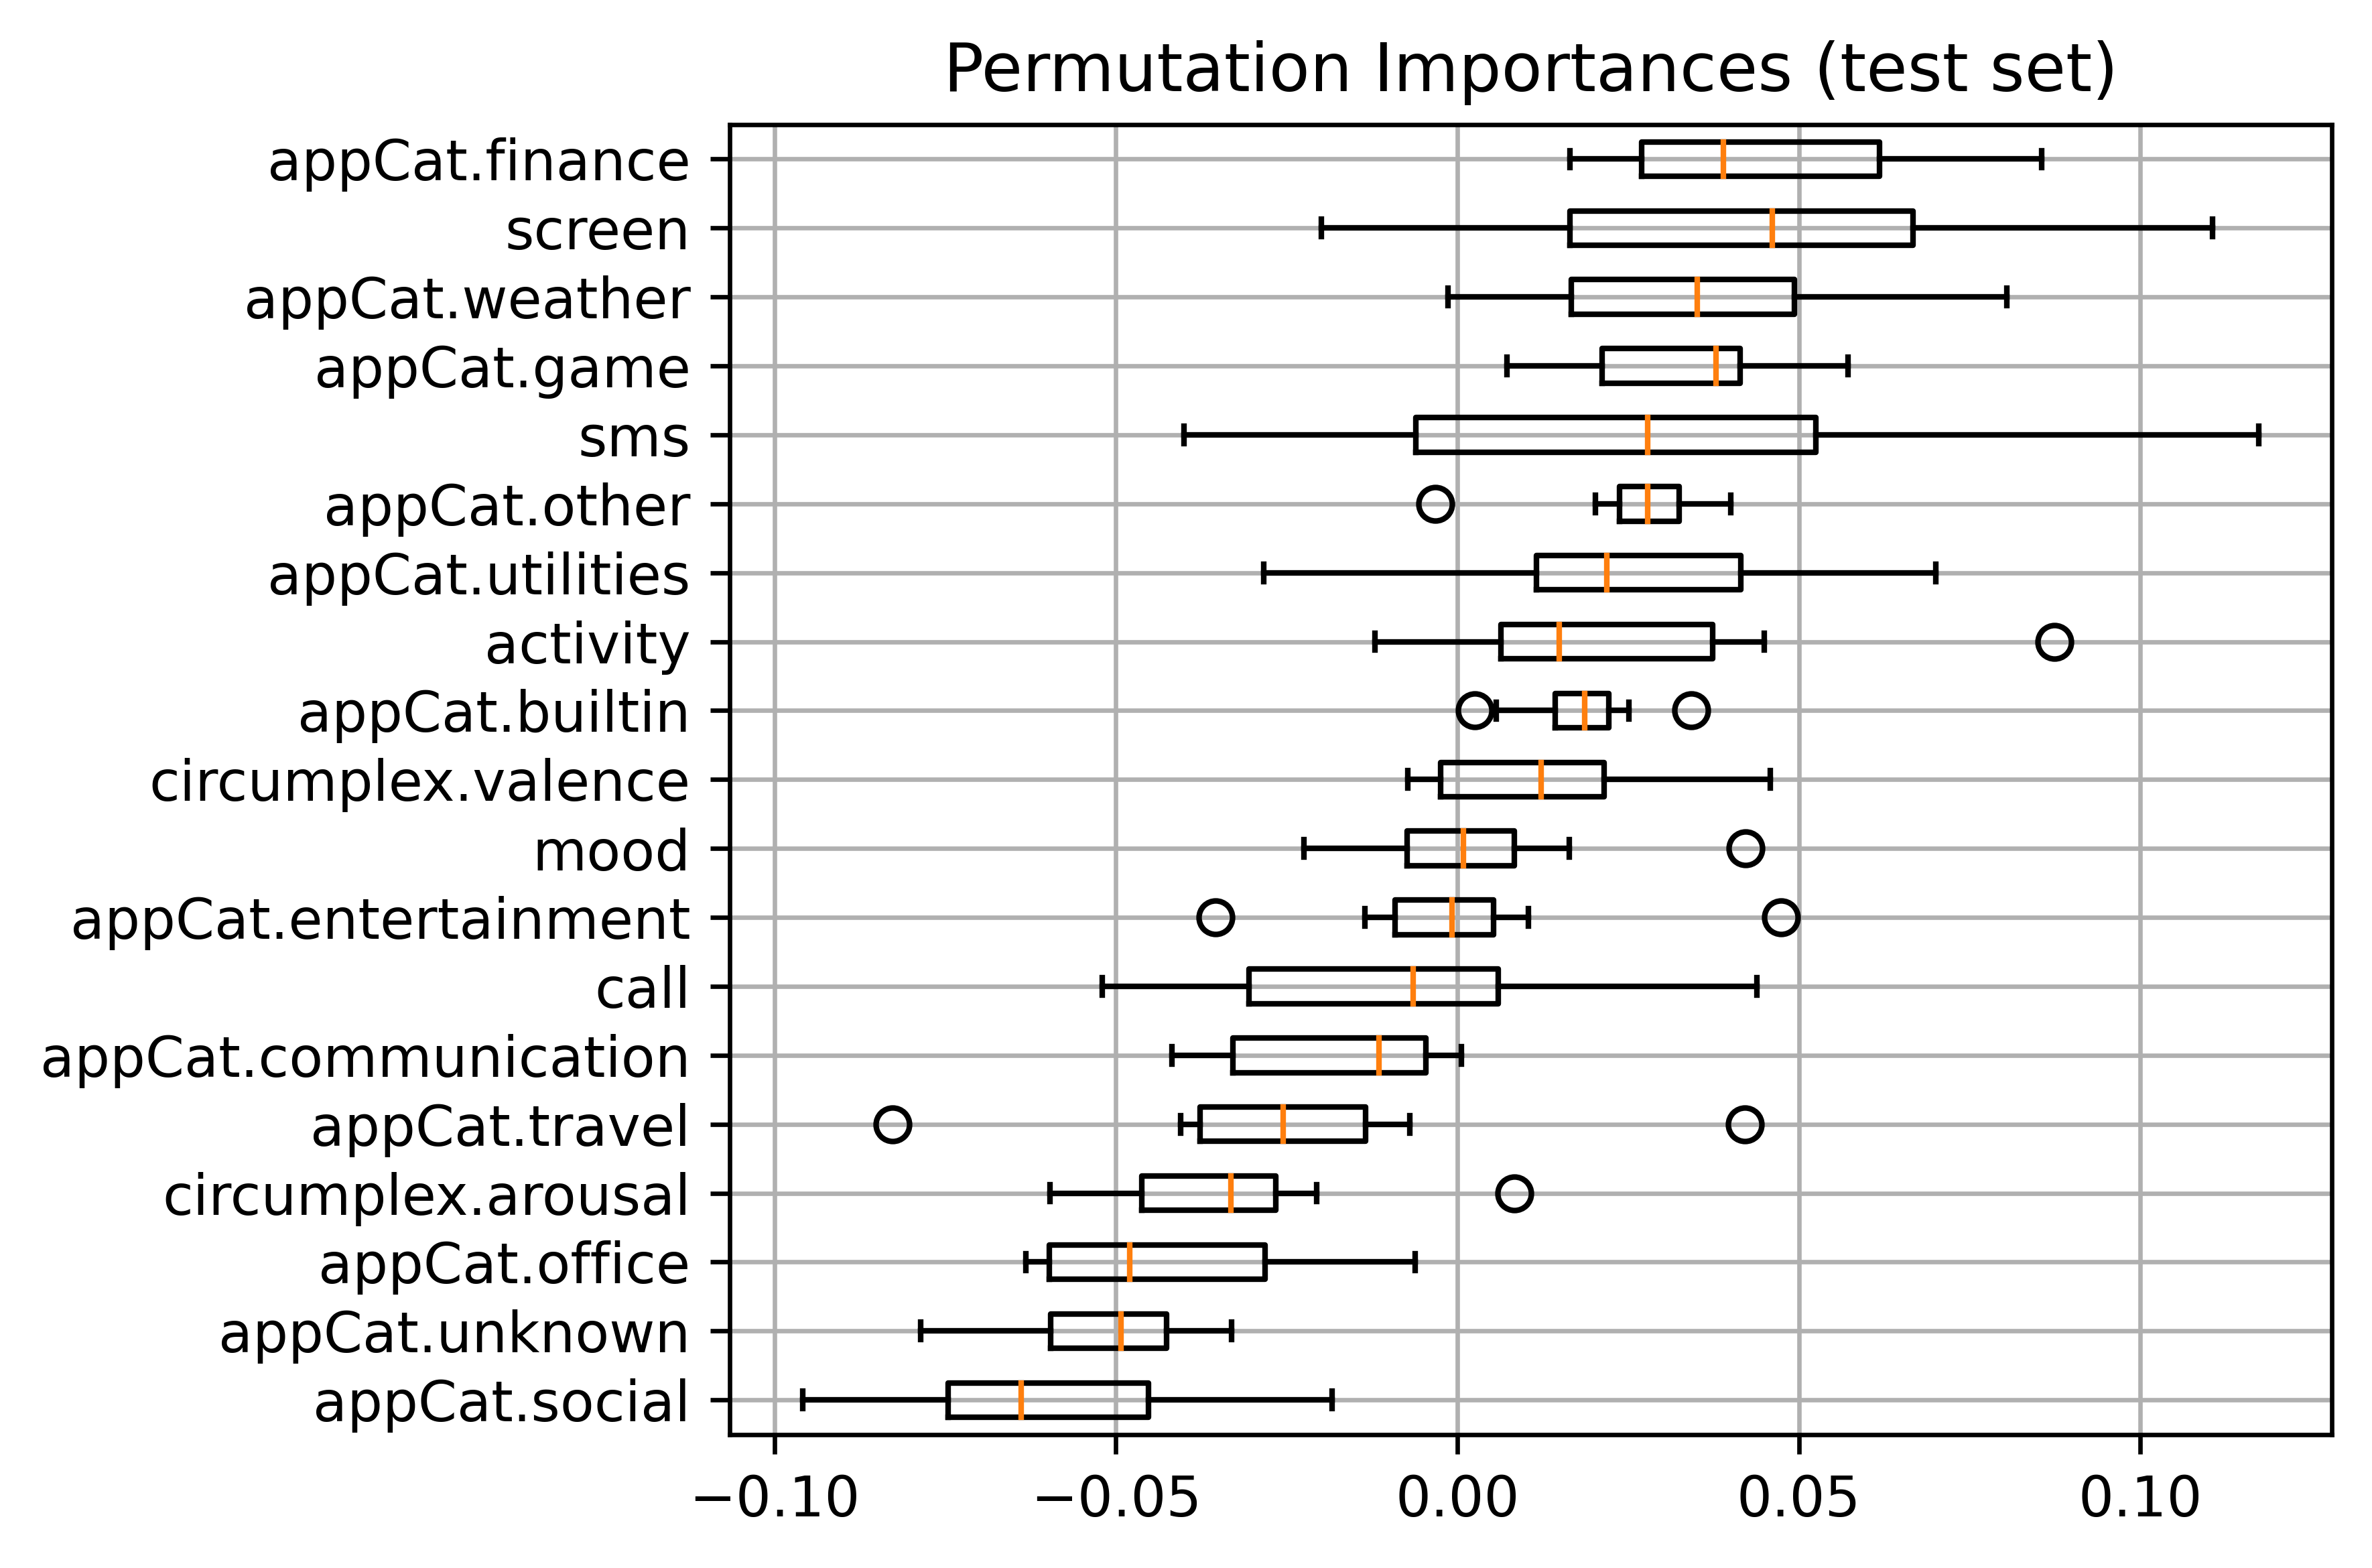

In [98]:
#result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)

svr = svm.SVR()
svr.fit(X_train, y_train)

result = permutation_importance(svr, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(dpi=600)
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.grid()
#plt.show()
plt.savefig('svr_perm_importance.png', dpi = 600)

In [115]:
X_train

mood  circumplex.arousal  circumplex.valence  activity  \
index_col                                                                
2014-03-29  0.255981            0.824373            0.296830  0.400961   
2014-03-31  0.338517            0.851254            0.270893  0.347667   
2014-04-02  0.350478            0.887097            0.328530  0.334506   
2014-04-03  0.364833            0.736559            0.293948  0.254926   
2014-04-05  0.393541            0.629032            0.311239  0.144319   
...              ...                 ...                 ...       ...   
2014-05-25  0.018931            0.836145            0.031579  0.181945   
2014-05-26  0.049222            0.706024            0.031579  0.151971   
2014-05-28  0.152714            0.754217            0.103759  0.272192   
2014-05-29  0.228439            0.561446            0.148872  0.328871   
2014-05-30  0.213294            0.387952            0.022556  0.499695   

              screen      call       sms  appCat.builtin  \
index_col                                                  
2014-03-29  0.311114  0.827586  0.133333        0.430655   
2014-03-31  0.283402  1.000000  0.000000        0.445374   
2014-04-02  0.406691  0.965517  0.000000        0.476869   
2014-04-03  0.458981  0.905172  0.000000        0.452171   
2014-04-05  0.416180  0.965517  0.000000        0.887925   
...              ...       ...       ...             ...   
2014-05-25  0.019774  0.554113  0.416667        0.202926   
2014-05-26  0.020989  0.865801  1.000000        0.081159   
2014-05-28  0.120650  1.000000  0.833333        0.271906   
2014-05-29  0.000000  0.939394  0.555556        0.031137   
2014-05-30  0.040251  0.727273  0.555556        0.100644   

            appCat.communication  appCat.entertainment  appCat.finance  \
index_col                                                                
2014-03-29              0.291725              0.207429        0.049010   
2014-03-31              0.246651              0.295048        0.046007   
2014-04-02              0.278001              0.331285        0.134017   
2014-04-03              0.624378              0.354602        0.145693   
2014-04-05              0.493698              0.353221        0.170713   
...                          ...                   ...             ...   
2014-05-25              0.487308              0.367353        0.000000   
2014-05-26              0.260800              0.268861        0.000000   
2014-05-28              0.390314              0.182048        0.000000   
2014-05-29              0.168687              0.072613        0.000000   
2014-05-30              0.251096              0.000000        0.000000   

            appCat.game  appCat.office  appCat.other  appCat.social  \
index_col                                                             
2014-03-29     1.000000       0.651549      0.417441       0.297353   
2014-03-31     0.582822       0.651549      0.501215       0.274092   
2014-04-02     0.582822       0.604294      0.730684       0.315501   
2014-04-03     0.582822       0.472393      0.715301       0.276389   
2014-04-05     0.582822       0.472393      0.705179       0.274182   
...                 ...            ...           ...            ...   
2014-05-25     0.000000       0.750000      0.070836       0.080286   
2014-05-26     0.000000       0.000000      0.292039       0.156600   
2014-05-28     0.000000       1.000000      0.775472       0.214210   
2014-05-29     0.000000       1.000000      0.719294       0.023743   
2014-05-30     0.000000       1.000000      0.692167       0.038533   

            appCat.travel  appCat.unknown  appCat.utilities  appCat.weather  
index_col                                                                    
2014-03-29       0.439057        1.000000          0.152143             0.0  
2014-03-31       0.397287        0.556322          0.131870             0.0  
2014-04-02       0.397287        0.556322          0.150416             0

### The 10 important features/attributes determined using SFS. 

In [124]:
X_train[['appCat.finance', 'screen', 'appCat.weather', 'appCat.game', 'sms', 'appCat.other', 'appCat.utilities',
'activity', 'appCat.builtin', 'circumplex.valence']].head()

appCat.finance    screen  appCat.weather  appCat.game       sms  \
index_col                                                                     
2014-03-29        0.049010  0.311114             0.0     1.000000  0.133333   
2014-03-31        0.046007  0.283402             0.0     0.582822  0.000000   
2014-04-02        0.134017  0.406691             0.0     0.582822  0.000000   
2014-04-03        0.145693  0.458981             0.0     0.582822  0.000000   
2014-04-05        0.170713  0.416180             0.0     0.582822  0.000000   

            appCat.other  appCat.utilities  activity  appCat.builtin  \
index_col                                                              
2014-03-29      0.417441          0.152143  0.400961        0.430655   
2014-03-31      0.501215          0.131870  0.347667        0.445374   
2014-04-02      0.730684          0.150416  0.334506        0.476869   
2014-04-03      0.715301          0.040082  0.254926        0.452171   
2014-04-05      0.705179          0.040436  0.144319        0.887925   

            circumplex.valence  
index_col                       
2014-03-29            0.296830  
2014-03-31            0.270893  
2014-04-02            0.328530  
2014-04-03            0.293948  
2014-04-05            0.311239

In [100]:
X_train = X_train[X_train.columns[sfs_forward.get_support()].tolist()]
X_test = X_test[X_test.columns[sfs_forward.get_support()].tolist()]

In [109]:
X_train.head()

mood  circumplex.arousal  circumplex.valence  activity  \
index_col                                                                
2014-03-29  0.255981            0.824373            0.296830  0.400961   
2014-03-31  0.338517            0.851254            0.270893  0.347667   
2014-04-02  0.350478            0.887097            0.328530  0.334506   
2014-04-03  0.364833            0.736559            0.293948  0.254926   
2014-04-05  0.393541            0.629032            0.311239  0.144319   

              screen      call       sms  appCat.finance  appCat.office  \
index_col                                                                 
2014-03-29  0.311114  0.827586  0.133333        0.049010       0.651549   
2014-03-31  0.283402  1.000000  0.000000        0.046007       0.651549   
2014-04-02  0.406691  0.965517  0.000000        0.134017       0.604294   
2014-04-03  0.458981  0.905172  0.000000        0.145693       0.472393   
2014-04-05  0.416180  0.965517  0.000000        0.170713       0.472393   

            appCat.social  appCat.utilities  appCat.weather  
index_col                                                    
2014-03-29       0.297353          0.152143             0.0  
2014-03-31       0.274092          0.131870             0.0  
2014-04-02       0.315501          0.150416             0.0  
2014-04-03       0.276389          0.040082             0.0  
2014-04-05       0.274182          0.040436             0.0

## Parameter tuning

In [102]:
'''Define an accuracy evaluating function'''
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average mean absolute error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%'.format(accuracy))
    
    return accuracy

base_model = svm.SVR()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average mean absolute error: 0.5405
Accuracy = 92.16%


NameError: name 'rf_random' is not defined

### Using GridSearch on a parameterspace 

In [106]:
'''param_grid = {
    'bootstrap': [True],
    'max_depth': [300, 350, 400, 450],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [700, 1000, 1300, 1600, 1900]
}'''

param_grid = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
               'degree':[int(x) for x in np.arange(1,6)],
               'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
               'C': [1, 10, 100, 1000, 10000]}]


# Create a base model
sv = svm.SVR()
#rf = RandomForestRegressor(random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sv, param_grid = param_grid, cv = 5, n_jobs = -1, 
                           scoring='neg_mean_squared_error',verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000, 10000],
                          'degree': [1, 2, 3, 4, 5],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.6,
                                    0.9],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             scoring='neg_mean_squared_error', verbose=2)

In [107]:
grid_search.best_params_

{'C': 1, 'degree': 1, 'gamma': 0.9, 'kernel': 'rbf'}

In [108]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average mean absolute error: 0.5385
Accuracy = 92.19%
Improvement of 0.03%.


In [128]:
sv_opt = svm.SVR(kernel ='rbf', C=1, degree=1, gamma=0.9)
sv_opt.fit(X_train, y_train)
print('Test:',evaluate(sv_opt, X_test, y_test))
print('Bench',evaluate(sv_opt, X_test, y_bench) )

Model Performance
Average mean absolute error: 0.4935
Accuracy = 92.81%
Test 92.81443446496009
Model Performance
Average mean absolute error: 0.4442
Accuracy = 93.38%
Bench 93.37991306259305


## LSTM

### The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this standardization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [10]:
df = clean_data.drop(columns=['id'])
df = df.sort_index()
column_indices = {name: i for i, name in enumerate(df.columns)}

'''Splitting (70,20,10)'''
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

'''Scaling'''

train_max = train_df.max()
train_min = train_df.min()

train_df = (train_df - train_min) / (train_max - train_min)
val_df = (val_df - train_min) / (train_max - train_min)
val_df = val_df[:].mask(val_df[:]<0)
test_df = (test_df - train_min) / (train_max - train_min)
test_df = test_df[:].mask(test_df[:]<0)

def knnimputer(df):
    idx = df.index
    cols = df.columns
    for i in cols:
        if df[i].isnull().all():
            df[i].fillna(0,inplace=True)
   
    imp = KNNImputer(missing_values=np.nan)
    imp.fit(df)
    imp_df = imp.transform(df)
    imp_df = pd.DataFrame(imp_df, columns = cols, index = idx)
    return imp_df

train_df = knnimputer(train_df)
val_df = knnimputer(val_df)
test_df = knnimputer(test_df)

In [11]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


In [12]:
w2 = WindowGenerator(input_width=10, label_width=1, shift=1, label_columns=['mood'])
w2

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['mood']

In [13]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :] 
    if self.label_columns is not None: 
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [14]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 11, 19)
Inputs shape: (3, 10, 19)
labels shape: (3, 1, 1)


In [15]:
w2.example = example_inputs, example_labels

In [16]:
def plot(self, model=None, plot_col='mood', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            #print(np.shape(self.label_indices), np.shape(predictions[n, :, label_col_index]))
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [days]')

WindowGenerator.plot = plot

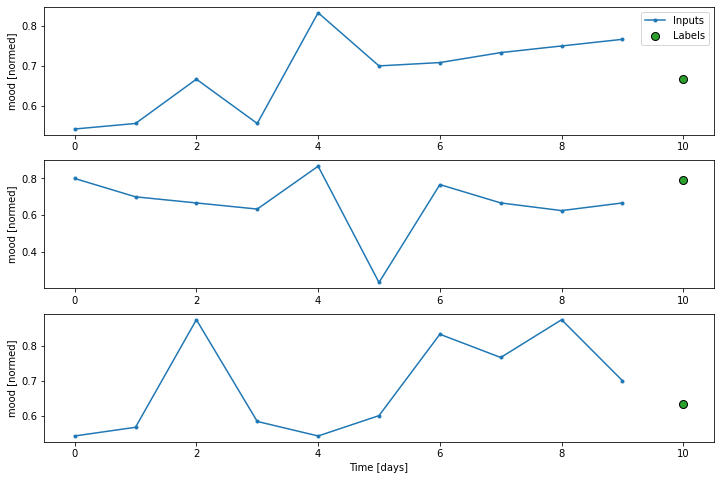

In [17]:
w2.plot()

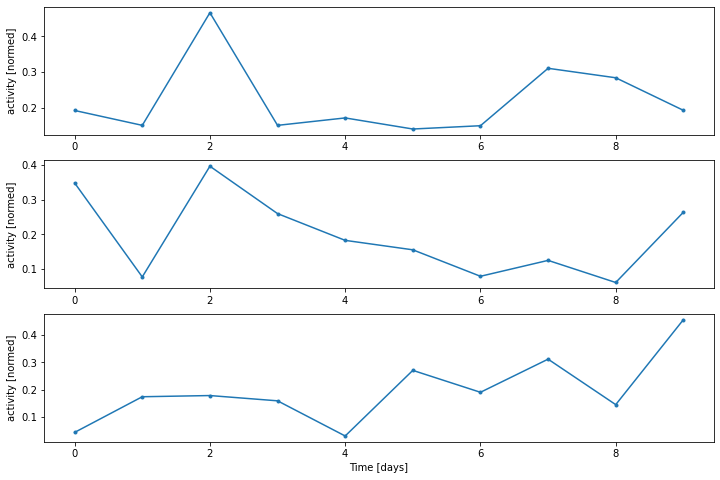

In [18]:
w2.plot(plot_col='activity')

In [19]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size, 
                                                              sequence_stride=1, shuffle=True, batch_size=32,)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
w2.train.element_spec

Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['mood']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['mood']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(TensorSpec(shape=(None, 10, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [22]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 10, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [23]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['mood'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['mood']

In [24]:
class Benchmark(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [25]:
benchmark = Benchmark(label_index=column_indices['mood'])

benchmark.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanSquaredError()])

val_performance = {}
performance = {}
val_performance['Benchmark'] = benchmark.evaluate(single_step_window.val)
performance['Benchmark'] = benchmark.evaluate(single_step_window.test, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - 0s 2ms/step - loss: 0.0259 - mean_squared_error: 0.0259


In [26]:
wide_window = WindowGenerator(input_width=10, label_width=10, shift=1, label_columns=['mood'])

wide_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 1  2  3  4  5  6  7  8  9 10]
Label column name(s): ['mood']

In [27]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', benchmark(wide_window.example[0]).shape)

Input shape: (32, 10, 19)
Output shape: (32, 10, 1)


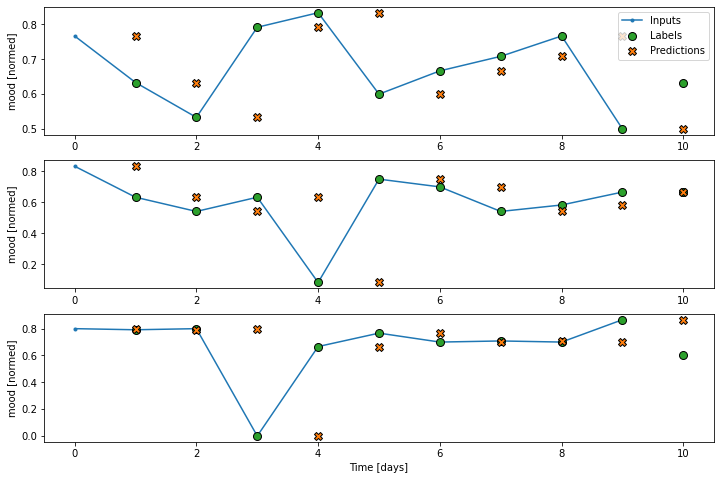

In [28]:
wide_window.plot(benchmark)

In [29]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanSquaredError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])
    
    return history

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(32, return_sequences=True), tf.keras.layers.Dense(units=1)])
    
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)    

Input shape: (32, 10, 19)
Output shape: (32, 10, 1)


In [30]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 0.3391 - mean_squared_error: 0.33 - ETA: 0s - loss: 0.2360 - mean_squared_error: 0.23 - ETA: 0s - loss: 0.1357 - mean_squared_error: 0.13 - 1s 18ms/step - loss: 0.1251 - mean_squared_error: 0.1251 - val_loss: 0.0645 - val_mean_squared_error: 0.0645
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 0.0650 - mean_squared_error: 0.06 - ETA: 0s - loss: 0.0617 - mean_squared_error: 0.06 - 0s 5ms/step - loss: 0.0561 - mean_squared_error: 0.0561 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 0.0478 - mean_squared_error: 0.04 - ETA: 0s - loss: 0.0439 - mean_squared_error: 0.04 - 0s 5ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0332 - val_mean_squared_error: 0.0332
Epoch 4/20
28/28 [==============================] - ETA: 0s - loss: 0.0376 - mean_squared_error: 0.03 - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.03 -

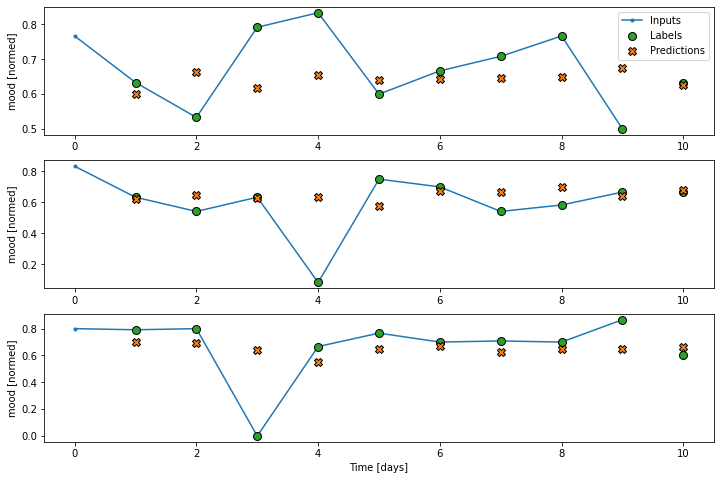

In [31]:
wide_window.plot(lstm_model)

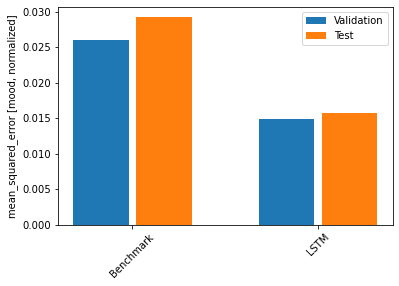

In [32]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_squared_error')
val_mse = [v[metric_index] for v in val_performance.values()]
test_mse = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_squared_error [mood, normalized]')
plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

## Parameter tuning

In [60]:
def build_model(hp):
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model = Sequential()
    model.add(LSTM(units=hp_units, activation='relu'))
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', metrics=['mse'], 
                  optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate))
    return model

tuner =  kt.Hyperband(build_model, objective='mse', max_epochs=10, factor=3, 
                      directory='my_dir', project_name='intro_to_kt', overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

tuner.search(wide_window.train, epochs=50, validation_data = wide_window.val, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.""")

Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.6675 - mse: 0.467 - ETA: 0s - loss: 0.6494 - mse: 0.438 - ETA: 0s - loss: 0.6312 - mse: 0.415 - ETA: 0s - loss: 0.6102 - mse: 0.389 - ETA: 0s - loss: 0.6012 - mse: 0.378 - ETA: 0s - loss: 0.5804 - mse: 0.355 - ETA: 0s - loss: 0.5705 - mse: 0.344 - ETA: 0s - loss: 0.5485 - mse: 0.321 - ETA: 0s - loss: 0.5280 - mse: 0.301 - ETA: 0s - loss: 0.5171 - mse: 0.291 - ETA: 0s - loss: 0.4942 - mse: 0.270 - ETA: 0s - loss: 0.4718 - mse: 0.252 - ETA: 0s - loss: 0.4481 - mse: 0.234 - ETA: 0s - loss: 0.4232 - mse: 0.217 - ETA: 0s - loss: 0.3988 - mse: 0.201 - 1s 50ms/step - loss: 0.3832 - mse: 0.1923 - val_loss: 0.1137 - val_mse: 0.0210
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.1215 - mse: 0.025 - ETA: 0s - loss: 0.1300 - mse: 0.027 - ETA: 0s - loss: 0.1354 - mse: 0.030 - ETA: 0s - loss: 0.1350 - mse: 0.030 - ETA: 0s - loss: 0.1285 - mse: 0.027 - ETA: 0s - loss: 0.1223 - mse: 0.025 - ETA: 0s - loss: 0.118

Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.6316 - mse: 0.412 - ETA: 0s - loss: 0.6085 - mse: 0.384 - ETA: 0s - loss: 0.5777 - mse: 0.349 - 0s 12ms/step - loss: 0.5737 - mse: 0.3450 - val_loss: 0.5434 - val_mse: 0.3093
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.5173 - mse: 0.281 - ETA: 0s - loss: 0.4919 - mse: 0.256 - ETA: 0s - loss: 0.4512 - mse: 0.218 - 0s 7ms/step - loss: 0.4512 - mse: 0.2185 - val_loss: 0.3951 - val_mse: 0.1697


Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.6623 - mse: 0.454 - ETA: 0s - loss: 0.4576 - mse: 0.246 - ETA: 0s - loss: 0.3437 - mse: 0.164 - ETA: 0s - loss: 0.2758 - mse: 0.122 - ETA: 0s - loss: 0.2455 - mse: 0.100 - ETA: 0s - loss: 0.2199 - mse: 0.085 - ETA: 0s - loss: 0.2026 - mse: 0.075 - ETA: 0s - loss: 0.1888 - mse: 0.067 - ETA: 0s - loss: 0.1748 - mse: 0.059 - 1s 30ms/step - loss: 0.1708 - mse: 0.0575 - val_loss: 0.0903 - val_mse: 0.0138
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.1002 - mse: 0.017 - ETA: 0s - loss: 0.0928 - mse: 0.015 - ETA: 0s - loss: 0.0920 - mse: 0.015 - ETA: 0s - loss: 0.0927 - mse: 0.015 - ETA: 0s - loss: 0.0928 - mse: 0.015 - ETA: 0s - loss: 0.0931 - mse: 0.015 - ETA: 0s - loss: 0.0935 - mse: 0.015 - ETA: 0s - loss: 0.0928 - mse: 0.015 - ETA: 0s - loss: 0.0925 - mse: 0.015 - ETA: 0s - loss: 0.0925 - mse: 0.015 - 1s 24ms/step - loss: 0.0925 - mse: 0.0155 - val_loss: 0.0900 - val_mse: 0.0138


Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.6798 - mse: 0.477 - ETA: 0s - loss: 0.8121 - mse: 0.848 - ETA: 0s - loss: 0.6581 - mse: 0.579 - ETA: 0s - loss: 0.5155 - mse: 0.419 - ETA: 0s - loss: 0.4319 - mse: 0.331 - ETA: 0s - loss: 0.3726 - mse: 0.273 - ETA: 0s - loss: 0.3305 - mse: 0.232 - ETA: 0s - loss: 0.3004 - mse: 0.204 - ETA: 0s - loss: 0.2768 - mse: 0.182 - ETA: 0s - loss: 0.2606 - mse: 0.167 - 1s 30ms/step - loss: 0.2606 - mse: 0.1673 - val_loss: 0.1028 - val_mse: 0.0167
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.0909 - mse: 0.013 - ETA: 0s - loss: 0.0910 - mse: 0.014 - ETA: 0s - loss: 0.0924 - mse: 0.015 - ETA: 0s - loss: 0.0935 - mse: 0.015 - ETA: 0s - loss: 0.0946 - mse: 0.016 - ETA: 0s - loss: 0.0942 - mse: 0.016 - ETA: 0s - loss: 0.0936 - mse: 0.015 - ETA: 0s - loss: 0.0934 - mse: 0.015 - ETA: 0s - loss: 0.0930 - mse: 0.015 - ETA: 0s - loss: 0.0927 - mse: 0.015 - 1s 24ms/step - loss: 0.0926 - mse: 0.0157 - val_loss: 0.090

Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.7165 - mse: 0.531 - ETA: 0s - loss: 0.5790 - mse: 0.362 - ETA: 0s - loss: 0.4342 - mse: 0.242 - ETA: 0s - loss: 0.3677 - mse: 0.189 - ETA: 0s - loss: 0.2917 - mse: 0.138 - ETA: 0s - loss: 0.2673 - mse: 0.120 - ETA: 0s - loss: 0.2476 - mse: 0.106 - ETA: 0s - loss: 0.2290 - mse: 0.095 - ETA: 0s - loss: 0.2159 - mse: 0.087 - ETA: 0s - loss: 0.2049 - mse: 0.080 - ETA: 0s - loss: 0.1948 - mse: 0.074 - ETA: 0s - loss: 0.1872 - mse: 0.070 - ETA: 0s - loss: 0.1805 - mse: 0.065 - 1s 40ms/step - loss: 0.1762 - mse: 0.0634 - val_loss: 0.0932 - val_mse: 0.0147
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.0974 - mse: 0.017 - ETA: 0s - loss: 0.0979 - mse: 0.017 - ETA: 0s - loss: 0.0946 - mse: 0.016 - ETA: 0s - loss: 0.0965 - mse: 0.016 - ETA: 0s - loss: 0.0955 - mse: 0.016 - ETA: 0s - loss: 0.0948 - mse: 0.015 - ETA: 0s - loss: 0.0939 - mse: 0.015 - ETA: 0s - loss: 0.0938 - mse: 0.015 - ETA: 0s - loss: 0.093

Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.6174 - mse: 0.397 - ETA: 0s - loss: 17.7030 - mse: 616.13 - ETA: 0s - loss: 9.0260 - mse: 308.1531 - ETA: 0s - loss: 6.1857 - mse: 205.525 - ETA: 0s - loss: 5.3551 - mse: 176.186 - ETA: 0s - loss: 4.2008 - mse: 137.042 - ETA: 0s - loss: 3.8080 - mse: 123.347 - ETA: 0s - loss: 3.2045 - mse: 102.798 - ETA: 0s - loss: 2.7612 - mse: 88.115 - ETA: 0s - loss: 2.4334 - mse: 77.10 - ETA: 0s - loss: 2.2977 - mse: 72.57 - ETA: 0s - loss: 2.0671 - mse: 64.93 - ETA: 0s - loss: 1.8790 - mse: 58.75 - ETA: 0s - loss: 1.7985 - mse: 56.08 - ETA: 0s - loss: 1.6583 - mse: 51.40 - ETA: 0s - loss: 1.5387 - mse: 47.45 - ETA: 0s - loss: 1.4643 - mse: 45.02 - 2s 54ms/step - loss: 1.4643 - mse: 45.0222 - val_loss: 0.1011 - val_mse: 0.0164
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.0999 - mse: 0.018 - ETA: 0s - loss: 0.0998 - mse: 0.017 - ETA: 0s - loss: 0.0983 - mse: 0.016 - ETA: 0s - loss: 0.0978 - mse: 0.016 - ETA:

Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.7285 - mse: 0.545 - ETA: 0s - loss: 0.1943 - mse: 0.085 - ETA: 0s - loss: 0.1414 - mse: 0.048 - 0s 12ms/step - loss: 0.1298 - mse: 0.0409 - val_loss: 0.0931 - val_mse: 0.0144
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.0949 - mse: 0.016 - ETA: 0s - loss: 0.0936 - mse: 0.015 - ETA: 0s - loss: 0.0929 - mse: 0.015 - 0s 6ms/step - loss: 0.0928 - mse: 0.0155 - val_loss: 0.0891 - val_mse: 0.0137


Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.6713 - mse: 0.464 - ETA: 0s - loss: 0.5788 - mse: 0.357 - ETA: 0s - loss: 0.3961 - mse: 0.210 - ETA: 0s - loss: 0.3810 - mse: 0.192 - ETA: 0s - loss: 0.3214 - mse: 0.150 - ETA: 0s - loss: 0.2953 - mse: 0.134 - ETA: 0s - loss: 0.2811 - mse: 0.123 - ETA: 0s - loss: 0.2710 - mse: 0.115 - ETA: 0s - loss: 0.2519 - mse: 0.101 - ETA: 0s - loss: 0.2410 - mse: 0.095 - ETA: 0s - loss: 0.2301 - mse: 0.089 - ETA: 0s - loss: 0.2158 - mse: 0.081 - ETA: 0s - loss: 0.2114 - mse: 0.078 - ETA: 0s - loss: 0.2002 - mse: 0.072 - ETA: 0s - loss: 0.1950 - mse: 0.069 - ETA: 0s - loss: 0.1870 - mse: 0.064 - ETA: 0s - loss: 0.1809 - mse: 0.061 - ETA: 0s - loss: 0.1780 - mse: 0.059 - ETA: 0s - loss: 0.1749 - mse: 0.057 - ETA: 0s - loss: 0.1716 - mse: 0.056 - 2s 60ms/step - loss: 0.1705 - mse: 0.0555 - val_loss: 0.0983 - val_mse: 0.0162
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.1004 - mse: 0.017 - ETA: 0s - loss: 0.104

Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.7511 - mse: 0.578 - ETA: 0s - loss: 0.2344 - mse: 0.104 - ETA: 0s - loss: 0.1594 - mse: 0.055 - 0s 13ms/step - loss: 0.1488 - mse: 0.0489 - val_loss: 0.0896 - val_mse: 0.0136
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.0987 - mse: 0.016 - ETA: 0s - loss: 0.0934 - mse: 0.015 - ETA: 0s - loss: 0.0910 - mse: 0.015 - ETA: 0s - loss: 0.0906 - mse: 0.015 - 0s 9ms/step - loss: 0.0910 - mse: 0.0152 - val_loss: 0.0881 - val_mse: 0.0134


Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.7083 - mse: 0.517 - ETA: 0s - loss: 0.6924 - mse: 0.495 - ETA: 0s - loss: 0.6713 - mse: 0.467 - ETA: 0s - loss: 0.6412 - mse: 0.427 - ETA: 0s - loss: 0.6101 - mse: 0.391 - 0s 17ms/step - loss: 0.5996 - mse: 0.3793 - val_loss: 0.4902 - val_mse: 0.2540
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.4776 - mse: 0.241 - ETA: 0s - loss: 0.4389 - mse: 0.206 - ETA: 0s - loss: 0.4025 - mse: 0.177 - ETA: 0s - loss: 0.3565 - mse: 0.144 - ETA: 0s - loss: 0.3043 - mse: 0.116 - 0s 11ms/step - loss: 0.3013 - mse: 0.1146 - val_loss: 0.0927 - val_mse: 0.0141


Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.6891 - mse: 0.491 - ETA: 0s - loss: 1.8541 - mse: 6.999 - ETA: 0s - loss: 1.1785 - mse: 3.633 - ETA: 0s - loss: 0.9662 - mse: 2.756 - ETA: 0s - loss: 0.7438 - mse: 2.014 - ETA: 0s - loss: 0.6504 - mse: 1.708 - ETA: 0s - loss: 0.5475 - mse: 1.391 - ETA: 0s - loss: 0.4783 - mse: 1.175 - ETA: 0s - loss: 0.4260 - mse: 1.017 - ETA: 0s - loss: 0.3876 - mse: 0.897 - ETA: 0s - loss: 0.3657 - mse: 0.832 - 1s 36ms/step - loss: 0.3617 - mse: 0.8200 - val_loss: 0.1069 - val_mse: 0.0178
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.1032 - mse: 0.017 - ETA: 0s - loss: 0.1041 - mse: 0.018 - ETA: 0s - loss: 0.0988 - mse: 0.016 - ETA: 0s - loss: 0.0979 - mse: 0.016 - ETA: 0s - loss: 0.0977 - mse: 0.016 - ETA: 0s - loss: 0.0971 - mse: 0.016 - ETA: 0s - loss: 0.0973 - mse: 0.016 - ETA: 0s - loss: 0.0957 - mse: 0.016 - ETA: 0s - loss: 0.0961 - mse: 0.016 - ETA: 0s - loss: 0.0954 - mse: 0.016 - ETA: 0s - loss: 0.095

Epoch 1/2
28/28 [==============================] - ETA: 0s - loss: 0.6923 - mse: 0.495 - ETA: 0s - loss: 0.6750 - mse: 0.471 - ETA: 0s - loss: 0.6459 - mse: 0.433 - 0s 14ms/step - loss: 0.6344 - mse: 0.4194 - val_loss: 0.5793 - val_mse: 0.3495
Epoch 2/2
28/28 [==============================] - ETA: 0s - loss: 0.5814 - mse: 0.352 - ETA: 0s - loss: 0.5376 - mse: 0.304 - ETA: 0s - loss: 0.5087 - mse: 0.274 - 0s 8ms/step - loss: 0.4928 - mse: 0.2590 - val_loss: 0.4160 - val_mse: 0.1868


Epoch 3/4
28/28 [==============================] - ETA: 0s - loss: 0.6492 - mse: 0.436 - ETA: 0s - loss: 0.5097 - mse: 0.457 - ETA: 0s - loss: 0.3576 - mse: 0.259 - ETA: 0s - loss: 0.2761 - mse: 0.178 - 0s 15ms/step - loss: 0.2761 - mse: 0.1781 - val_loss: 0.1151 - val_mse: 0.0198
Epoch 4/4
28/28 [==============================] - ETA: 0s - loss: 0.1059 - mse: 0.018 - ETA: 0s - loss: 0.0992 - mse: 0.017 - ETA: 0s - loss: 0.0965 - mse: 0.016 - 0s 8ms/step - loss: 0.0955 - mse: 0.0164 - val_loss: 0.0952 - val_mse: 0.0150


Epoch 3/4
28/28 [==============================] - ETA: 0s - loss: 0.6320 - mse: 0.415 - ETA: 0s - loss: 0.2616 - mse: 0.110 - ETA: 0s - loss: 0.1854 - mse: 0.064 - 0s 14ms/step - loss: 0.1652 - mse: 0.0534 - val_loss: 0.0951 - val_mse: 0.0150
Epoch 4/4
28/28 [==============================] - ETA: 0s - loss: 0.0957 - mse: 0.014 - ETA: 0s - loss: 0.0929 - mse: 0.015 - ETA: 0s - loss: 0.0935 - mse: 0.015 - 0s 7ms/step - loss: 0.0931 - mse: 0.0156 - val_loss: 0.0905 - val_mse: 0.0138


Epoch 3/4
28/28 [==============================] - ETA: 0s - loss: 0.6266 - mse: 0.405 - ETA: 0s - loss: 0.4148 - mse: 0.211 - ETA: 0s - loss: 0.3041 - mse: 0.136 - ETA: 0s - loss: 0.2450 - mse: 0.101 - ETA: 0s - loss: 0.2167 - mse: 0.083 - ETA: 0s - loss: 0.1949 - mse: 0.071 - ETA: 0s - loss: 0.1806 - mse: 0.063 - ETA: 0s - loss: 0.1690 - mse: 0.056 - ETA: 0s - loss: 0.1603 - mse: 0.051 - ETA: 0s - loss: 0.1537 - mse: 0.048 - 1s 32ms/step - loss: 0.1537 - mse: 0.0484 - val_loss: 0.0934 - val_mse: 0.0148
Epoch 4/4
28/28 [==============================] - ETA: 0s - loss: 0.0948 - mse: 0.017 - ETA: 0s - loss: 0.0931 - mse: 0.015 - ETA: 0s - loss: 0.0935 - mse: 0.015 - ETA: 0s - loss: 0.0938 - mse: 0.015 - ETA: 0s - loss: 0.0931 - mse: 0.015 - ETA: 0s - loss: 0.0929 - mse: 0.015 - ETA: 0s - loss: 0.0925 - mse: 0.015 - ETA: 0s - loss: 0.0921 - mse: 0.015 - ETA: 0s - loss: 0.0924 - mse: 0.015 - ETA: 0s - loss: 0.0923 - mse: 0.015 - 1s 25ms/step - loss: 0.0923 - mse: 0.0154 - val_loss: 0.091

Epoch 3/4
28/28 [==============================] - ETA: 0s - loss: 0.7002 - mse: 0.504 - ETA: 0s - loss: 0.5470 - mse: 0.328 - ETA: 0s - loss: 0.3885 - mse: 0.211 - ETA: 0s - loss: 0.3296 - mse: 0.164 - ETA: 0s - loss: 0.2785 - mse: 0.131 - ETA: 0s - loss: 0.2537 - mse: 0.112 - ETA: 0s - loss: 0.2335 - mse: 0.099 - ETA: 0s - loss: 0.2153 - mse: 0.088 - ETA: 0s - loss: 0.2050 - mse: 0.081 - ETA: 0s - loss: 0.1943 - mse: 0.074 - ETA: 0s - loss: 0.1846 - mse: 0.069 - ETA: 0s - loss: 0.1773 - mse: 0.064 - ETA: 0s - loss: 0.1712 - mse: 0.060 - ETA: 0s - loss: 0.1654 - mse: 0.057 - 1s 43ms/step - loss: 0.1644 - mse: 0.0567 - val_loss: 0.0967 - val_mse: 0.0158
Epoch 4/4
28/28 [==============================] - ETA: 0s - loss: 0.1019 - mse: 0.018 - ETA: 0s - loss: 0.0947 - mse: 0.016 - ETA: 0s - loss: 0.0940 - mse: 0.015 - ETA: 0s - loss: 0.0954 - mse: 0.015 - ETA: 0s - loss: 0.0951 - mse: 0.015 - ETA: 0s - loss: 0.0937 - mse: 0.015 - ETA: 0s - loss: 0.0947 - mse: 0.015 - ETA: 0s - loss: 0.094

Epoch 5/10
28/28 [==============================] - ETA: 0s - loss: 0.6652 - mse: 0.456 - ETA: 0s - loss: 0.4675 - mse: 0.254 - ETA: 0s - loss: 0.3684 - mse: 0.184 - ETA: 0s - loss: 0.2983 - mse: 0.136 - ETA: 0s - loss: 0.2590 - mse: 0.109 - ETA: 0s - loss: 0.2335 - mse: 0.092 - ETA: 0s - loss: 0.2102 - mse: 0.079 - ETA: 0s - loss: 0.1963 - mse: 0.071 - ETA: 0s - loss: 0.1839 - mse: 0.064 - ETA: 0s - loss: 0.1747 - mse: 0.059 - 1s 32ms/step - loss: 0.1737 - mse: 0.0589 - val_loss: 0.0917 - val_mse: 0.0142
Epoch 6/10
28/28 [==============================] - ETA: 0s - loss: 0.0853 - mse: 0.013 - ETA: 0s - loss: 0.0925 - mse: 0.015 - ETA: 0s - loss: 0.0973 - mse: 0.017 - ETA: 0s - loss: 0.0945 - mse: 0.016 - ETA: 0s - loss: 0.0942 - mse: 0.015 - ETA: 0s - loss: 0.0936 - mse: 0.015 - ETA: 0s - loss: 0.0932 - mse: 0.015 - ETA: 0s - loss: 0.0933 - mse: 0.015 - ETA: 0s - loss: 0.0933 - mse: 0.015 - ETA: 0s - loss: 0.0926 - mse: 0.015 - 1s 25ms/step - loss: 0.0926 - mse: 0.0155 - val_loss: 0.0

Epoch 5/10
28/28 [==============================] - ETA: 0s - loss: 0.7158 - mse: 0.528 - ETA: 0s - loss: 0.4616 - mse: 0.349 - ETA: 0s - loss: 0.3517 - mse: 0.214 - 0s 14ms/step - loss: 0.2715 - mse: 0.1488 - val_loss: 0.1110 - val_mse: 0.0187
Epoch 6/10
28/28 [==============================] - ETA: 0s - loss: 0.0996 - mse: 0.016 - ETA: 0s - loss: 0.0962 - mse: 0.016 - ETA: 0s - loss: 0.0952 - mse: 0.016 - 0s 8ms/step - loss: 0.0941 - mse: 0.0159 - val_loss: 0.0913 - val_mse: 0.0141
Epoch 7/10
28/28 [==============================] - ETA: 0s - loss: 0.1026 - mse: 0.019 - ETA: 0s - loss: 0.0922 - mse: 0.015 - ETA: 0s - loss: 0.0909 - mse: 0.015 - 0s 7ms/step - loss: 0.0909 - mse: 0.0151 - val_loss: 0.0896 - val_mse: 0.0137
Epoch 8/10
28/28 [==============================] - ETA: 0s - loss: 0.0901 - mse: 0.014 - ETA: 0s - loss: 0.0899 - mse: 0.014 - ETA: 0s - loss: 0.0910 - mse: 0.015 - 0s 7ms/step - loss: 0.0906 - mse: 0.0151 - val_loss: 0.0889 - val_mse: 0.0136
Epoch 9/10
28/28 [=====

Epoch 1/4
28/28 [==============================] - ETA: 0s - loss: 0.7145 - mse: 0.526 - ETA: 0s - loss: 2.5895 - mse: 15.08 - ETA: 0s - loss: 1.7788 - mse: 9.1836 - ETA: 0s - loss: 1.3954 - mse: 6.618 - ETA: 0s - loss: 1.1362 - mse: 5.162 - ETA: 0s - loss: 0.9560 - mse: 4.229 - ETA: 0s - loss: 0.8953 - mse: 3.883 - ETA: 0s - loss: 0.7886 - mse: 3.333 - ETA: 0s - loss: 0.7030 - mse: 2.919 - ETA: 0s - loss: 0.6391 - mse: 2.597 - ETA: 0s - loss: 0.5879 - mse: 2.340 - ETA: 0s - loss: 0.5441 - mse: 2.129 - ETA: 0s - loss: 0.5067 - mse: 1.953 - ETA: 0s - loss: 0.4909 - mse: 1.875 - ETA: 0s - loss: 0.4626 - mse: 1.738 - 1s 45ms/step - loss: 0.4572 - mse: 1.7129 - val_loss: 0.0924 - val_mse: 0.0144
Epoch 2/4
28/28 [==============================] - ETA: 0s - loss: 0.0882 - mse: 0.014 - ETA: 0s - loss: 0.0916 - mse: 0.015 - ETA: 0s - loss: 0.0934 - mse: 0.015 - ETA: 0s - loss: 0.0947 - mse: 0.015 - ETA: 0s - loss: 0.0931 - mse: 0.015 - ETA: 0s - loss: 0.0939 - mse: 0.015 - ETA: 0s - loss: 0.09

Epoch 1/4
28/28 [==============================] - ETA: 0s - loss: 0.6627 - mse: 0.453 - ETA: 0s - loss: 0.5356 - mse: 0.311 - ETA: 0s - loss: 0.3956 - mse: 0.206 - ETA: 0s - loss: 0.3581 - mse: 0.172 - ETA: 0s - loss: 0.2851 - mse: 0.126 - ETA: 0s - loss: 0.2627 - mse: 0.111 - ETA: 0s - loss: 0.2446 - mse: 0.099 - ETA: 0s - loss: 0.2269 - mse: 0.089 - ETA: 0s - loss: 0.2144 - mse: 0.081 - ETA: 0s - loss: 0.2044 - mse: 0.075 - ETA: 0s - loss: 0.1948 - mse: 0.070 - ETA: 0s - loss: 0.1868 - mse: 0.066 - ETA: 0s - loss: 0.1803 - mse: 0.062 - 1s 39ms/step - loss: 0.1762 - mse: 0.0599 - val_loss: 0.0901 - val_mse: 0.0136
Epoch 2/4
28/28 [==============================] - ETA: 0s - loss: 0.0922 - mse: 0.015 - ETA: 0s - loss: 0.0916 - mse: 0.015 - ETA: 0s - loss: 0.0945 - mse: 0.016 - ETA: 0s - loss: 0.0945 - mse: 0.016 - ETA: 0s - loss: 0.0932 - mse: 0.016 - ETA: 0s - loss: 0.0928 - mse: 0.015 - ETA: 0s - loss: 0.0925 - mse: 0.015 - ETA: 0s - loss: 0.0930 - mse: 0.015 - ETA: 0s - loss: 0.092

Epoch 1/4
28/28 [==============================] - ETA: 0s - loss: 0.7027 - mse: 0.506 - ETA: 0s - loss: 0.7073 - mse: 0.637 - ETA: 0s - loss: 0.5779 - mse: 0.442 - ETA: 0s - loss: 0.4384 - mse: 0.301 - ETA: 0s - loss: 0.3689 - mse: 0.241 - ETA: 0s - loss: 0.3143 - mse: 0.192 - ETA: 0s - loss: 0.2764 - mse: 0.161 - ETA: 0s - loss: 0.2559 - mse: 0.144 - 1s 26ms/step - loss: 0.2420 - mse: 0.1332 - val_loss: 0.1093 - val_mse: 0.0183
Epoch 2/4
28/28 [==============================] - ETA: 0s - loss: 0.1022 - mse: 0.018 - ETA: 0s - loss: 0.0967 - mse: 0.015 - ETA: 0s - loss: 0.0974 - mse: 0.016 - ETA: 0s - loss: 0.0960 - mse: 0.016 - ETA: 0s - loss: 0.0955 - mse: 0.016 - ETA: 0s - loss: 0.0952 - mse: 0.016 - ETA: 0s - loss: 0.0950 - mse: 0.016 - ETA: 0s - loss: 0.0942 - mse: 0.015 - 1s 21ms/step - loss: 0.0940 - mse: 0.0160 - val_loss: 0.0916 - val_mse: 0.0144
Epoch 3/4
28/28 [==============================] - ETA: 0s - loss: 0.0840 - mse: 0.013 - ETA: 0s - loss: 0.0882 - mse: 0.014 - ETA: 

Epoch 1/4
28/28 [==============================] - ETA: 0s - loss: 0.6527 - mse: 0.442 - ETA: 0s - loss: 0.9241 - mse: 2.716 - ETA: 0s - loss: 0.5546 - mse: 1.208 - 0s 15ms/step - loss: 0.4209 - mse: 0.8452 - val_loss: 0.1183 - val_mse: 0.0207
Epoch 2/4
28/28 [==============================] - ETA: 0s - loss: 0.1088 - mse: 0.019 - ETA: 0s - loss: 0.0993 - mse: 0.017 - ETA: 0s - loss: 0.0969 - mse: 0.016 - 0s 9ms/step - loss: 0.0954 - mse: 0.0163 - val_loss: 0.0908 - val_mse: 0.0143
Epoch 3/4
28/28 [==============================] - ETA: 0s - loss: 0.0853 - mse: 0.012 - ETA: 0s - loss: 0.0909 - mse: 0.014 - ETA: 0s - loss: 0.0920 - mse: 0.015 - ETA: 0s - loss: 0.0923 - mse: 0.015 - 0s 10ms/step - loss: 0.0924 - mse: 0.0156 - val_loss: 0.0911 - val_mse: 0.0142
Epoch 4/4
28/28 [==============================] - ETA: 0s - loss: 0.0934 - mse: 0.016 - ETA: 0s - loss: 0.0925 - mse: 0.015 - ETA: 0s - loss: 0.0920 - mse: 0.015 - 0s 9ms/step - loss: 0.0915 - mse: 0.0155 - val_loss: 0.0910 - val_

Epoch 1/4
28/28 [==============================] - ETA: 0s - loss: 0.6632 - mse: 0.451 - ETA: 0s - loss: 2.7810 - mse: 18.19 - ETA: 0s - loss: 1.8818 - mse: 11.03 - ETA: 0s - loss: 1.4663 - mse: 7.9401 - ETA: 0s - loss: 1.1896 - mse: 6.190 - ETA: 0s - loss: 0.9991 - mse: 5.070 - ETA: 0s - loss: 0.8671 - mse: 4.295 - ETA: 0s - loss: 0.7643 - mse: 3.724 - ETA: 0s - loss: 0.6883 - mse: 3.289 - ETA: 0s - loss: 0.6285 - mse: 2.945 - ETA: 0s - loss: 0.5778 - mse: 2.666 - ETA: 0s - loss: 0.5366 - mse: 2.436 - ETA: 0s - loss: 0.5023 - mse: 2.243 - ETA: 0s - loss: 0.4717 - mse: 2.078 - 1s 42ms/step - loss: 0.4660 - mse: 2.0474 - val_loss: 0.0973 - val_mse: 0.0155
Epoch 2/4
28/28 [==============================] - ETA: 0s - loss: 0.1016 - mse: 0.017 - ETA: 0s - loss: 0.1019 - mse: 0.017 - ETA: 0s - loss: 0.0992 - mse: 0.016 - ETA: 0s - loss: 0.0972 - mse: 0.016 - ETA: 0s - loss: 0.0967 - mse: 0.016 - ETA: 0s - loss: 0.0962 - mse: 0.016 - ETA: 0s - loss: 0.0950 - mse: 0.016 - ETA: 0s - loss: 0.09

Epoch 1/4
28/28 [==============================] - ETA: 0s - loss: 0.7208 - mse: 0.537 - ETA: 0s - loss: 4.9511 - mse: 42.78 - ETA: 0s - loss: 2.7219 - mse: 21.52 - ETA: 0s - loss: 2.2863 - mse: 17.28 - ETA: 0s - loss: 1.7547 - mse: 12.40 - ETA: 0s - loss: 1.4116 - mse: 9.6585 - ETA: 0s - loss: 1.1875 - mse: 7.910 - ETA: 0s - loss: 1.0235 - mse: 6.697 - ETA: 0s - loss: 0.9016 - mse: 5.806 - ETA: 0s - loss: 0.8099 - mse: 5.126 - ETA: 0s - loss: 0.7354 - mse: 4.588 - ETA: 0s - loss: 0.7033 - mse: 4.360 - ETA: 0s - loss: 0.6487 - mse: 3.965 - ETA: 0s - loss: 0.6249 - mse: 3.793 - ETA: 0s - loss: 0.5834 - mse: 3.492 - ETA: 0s - loss: 0.5642 - mse: 3.358 - ETA: 0s - loss: 0.5398 - mse: 3.186 - 2s 60ms/step - loss: 0.5398 - mse: 3.1866 - val_loss: 0.1006 - val_mse: 0.0163
Epoch 2/4
28/28 [==============================] - ETA: 0s - loss: 0.0916 - mse: 0.014 - ETA: 0s - loss: 0.0954 - mse: 0.015 - ETA: 0s - loss: 0.0953 - mse: 0.015 - ETA: 0s - loss: 0.0944 - mse: 0.015 - ETA: 0s - loss: 0.09

Epoch 5/10
28/28 [==============================] - ETA: 0s - loss: 0.6701 - mse: 0.463 - ETA: 0s - loss: 0.5174 - mse: 0.296 - ETA: 0s - loss: 0.3433 - mse: 0.168 - ETA: 0s - loss: 0.2850 - mse: 0.132 - ETA: 0s - loss: 0.2427 - mse: 0.102 - ETA: 0s - loss: 0.2226 - mse: 0.090 - ETA: 0s - loss: 0.2072 - mse: 0.080 - ETA: 0s - loss: 0.1959 - mse: 0.073 - ETA: 0s - loss: 0.1802 - mse: 0.065 - ETA: 0s - loss: 0.1688 - mse: 0.058 - ETA: 0s - loss: 0.1628 - mse: 0.055 - ETA: 0s - loss: 0.1580 - mse: 0.052 - 1s 38ms/step - loss: 0.1571 - mse: 0.0517 - val_loss: 0.0899 - val_mse: 0.0138
Epoch 6/10
28/28 [==============================] - ETA: 0s - loss: 0.0997 - mse: 0.017 - ETA: 0s - loss: 0.0927 - mse: 0.015 - ETA: 0s - loss: 0.0934 - mse: 0.015 - ETA: 0s - loss: 0.0924 - mse: 0.015 - ETA: 0s - loss: 0.0933 - mse: 0.015 - ETA: 0s - loss: 0.0920 - mse: 0.015 - ETA: 0s - loss: 0.0924 - mse: 0.015 - ETA: 0s - loss: 0.0918 - mse: 0.015 - ETA: 0s - loss: 0.0917 - mse: 0.015 - ETA: 0s - loss: 0.0

Epoch 5/10
28/28 [==============================] - ETA: 0s - loss: 0.7006 - mse: 0.506 - ETA: 0s - loss: 0.7490 - mse: 0.718 - ETA: 0s - loss: 0.5860 - mse: 0.473 - ETA: 0s - loss: 0.4640 - mse: 0.344 - ETA: 0s - loss: 0.3989 - mse: 0.283 - ETA: 0s - loss: 0.3551 - mse: 0.242 - ETA: 0s - loss: 0.3107 - mse: 0.203 - ETA: 0s - loss: 0.2790 - mse: 0.175 - 1s 27ms/step - loss: 0.2762 - mse: 0.1734 - val_loss: 0.1029 - val_mse: 0.0168
Epoch 6/10
28/28 [==============================] - ETA: 0s - loss: 0.0975 - mse: 0.015 - ETA: 0s - loss: 0.0966 - mse: 0.014 - ETA: 0s - loss: 0.0946 - mse: 0.015 - ETA: 0s - loss: 0.0956 - mse: 0.016 - ETA: 0s - loss: 0.0956 - mse: 0.016 - ETA: 0s - loss: 0.0958 - mse: 0.016 - ETA: 0s - loss: 0.0948 - mse: 0.016 - ETA: 0s - loss: 0.0950 - mse: 0.016 - ETA: 0s - loss: 0.0942 - mse: 0.016 - 1s 21ms/step - loss: 0.0942 - mse: 0.0160 - val_loss: 0.0916 - val_mse: 0.0142
Epoch 7/10
28/28 [==============================] - ETA: 0s - loss: 0.1005 - mse: 0.018 - ET

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 0.6154 - mse: 0.391 - ETA: 0s - loss: 0.6054 - mse: 0.380 - ETA: 0s - loss: 0.5867 - mse: 0.359 - ETA: 0s - loss: 0.5742 - mse: 0.344 - ETA: 0s - loss: 0.5559 - mse: 0.325 - ETA: 0s - loss: 0.5360 - mse: 0.304 - ETA: 0s - loss: 0.5168 - mse: 0.285 - ETA: 0s - loss: 0.4967 - mse: 0.266 - ETA: 0s - loss: 0.4761 - mse: 0.248 - ETA: 0s - loss: 0.4542 - mse: 0.230 - 1s 32ms/step - loss: 0.4433 - mse: 0.2220 - val_loss: 0.2119 - val_mse: 0.0557
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 0.2180 - mse: 0.058 - ETA: 0s - loss: 0.1756 - mse: 0.041 - ETA: 0s - loss: 0.1451 - mse: 0.031 - ETA: 0s - loss: 0.1320 - mse: 0.027 - ETA: 0s - loss: 0.1301 - mse: 0.026 - ETA: 0s - loss: 0.1281 - mse: 0.026 - ETA: 0s - loss: 0.1252 - mse: 0.025 - ETA: 0s - loss: 0.1208 - mse: 0.024 - ETA: 0s - loss: 0.1178 - mse: 0.023 - ETA: 0s - loss: 0.1154 - mse: 0.022 - 1s 26ms/step - loss: 0.1151 - mse: 0.0222 - val_loss: 0.0

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 0.7051 - mse: 0.514 - ETA: 0s - loss: 0.5167 - mse: 0.291 - ETA: 0s - loss: 0.3667 - mse: 0.176 - ETA: 0s - loss: 0.2824 - mse: 0.122 - ETA: 0s - loss: 0.2364 - mse: 0.095 - 1s 19ms/step - loss: 0.2138 - mse: 0.0829 - val_loss: 0.1000 - val_mse: 0.0160
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 0.1029 - mse: 0.018 - ETA: 0s - loss: 0.0948 - mse: 0.016 - ETA: 0s - loss: 0.0943 - mse: 0.015 - ETA: 0s - loss: 0.0941 - mse: 0.016 - ETA: 0s - loss: 0.0932 - mse: 0.015 - 0s 11ms/step - loss: 0.0928 - mse: 0.0157 - val_loss: 0.0906 - val_mse: 0.0141
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 0.0879 - mse: 0.014 - ETA: 0s - loss: 0.0902 - mse: 0.014 - ETA: 0s - loss: 0.0911 - mse: 0.014 - ETA: 0s - loss: 0.0913 - mse: 0.015 - ETA: 0s - loss: 0.0915 - mse: 0.015 - 0s 10ms/step - loss: 0.0915 - mse: 0.0154 - val_loss: 0.0897 - val_mse: 0.0138
Epoch 4/10
28/28 [===================

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 0.6629 - mse: 0.451 - ETA: 0s - loss: 0.6465 - mse: 0.433 - ETA: 1s - loss: 0.6334 - mse: 0.416 - ETA: 1s - loss: 0.6218 - mse: 0.402 - ETA: 0s - loss: 0.6048 - mse: 0.381 - ETA: 0s - loss: 0.5838 - mse: 0.357 - ETA: 0s - loss: 0.5738 - mse: 0.346 - ETA: 0s - loss: 0.5626 - mse: 0.334 - ETA: 0s - loss: 0.5522 - mse: 0.323 - ETA: 0s - loss: 0.5415 - mse: 0.312 - ETA: 0s - loss: 0.5194 - mse: 0.291 - ETA: 0s - loss: 0.5072 - mse: 0.279 - ETA: 0s - loss: 0.4958 - mse: 0.269 - ETA: 0s - loss: 0.4841 - mse: 0.259 - ETA: 0s - loss: 0.4719 - mse: 0.249 - ETA: 0s - loss: 0.4591 - mse: 0.239 - ETA: 0s - loss: 0.4459 - mse: 0.230 - ETA: 0s - loss: 0.4327 - mse: 0.221 - ETA: 0s - loss: 0.4192 - mse: 0.212 - ETA: 0s - loss: 0.4057 - mse: 0.203 - ETA: 0s - loss: 0.3926 - mse: 0.196 - ETA: 0s - loss: 0.3803 - mse: 0.188 - ETA: 0s - loss: 0.3619 - mse: 0.176 - 2s 63ms/step - loss: 0.3586 - mse: 0.1747 - val_loss: 0.1481 - val_mse: 0.

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 0.6641 - mse: 0.458 - ETA: 0s - loss: 0.6619 - mse: 0.453 - ETA: 0s - loss: 0.6377 - mse: 0.422 - ETA: 0s - loss: 0.6231 - mse: 0.404 - ETA: 0s - loss: 0.6085 - mse: 0.386 - ETA: 0s - loss: 0.5877 - mse: 0.362 - ETA: 0s - loss: 0.5667 - mse: 0.340 - ETA: 0s - loss: 0.5451 - mse: 0.317 - 1s 26ms/step - loss: 0.5369 - mse: 0.3097 - val_loss: 0.3648 - val_mse: 0.1465
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 0.3529 - mse: 0.138 - ETA: 0s - loss: 0.3271 - mse: 0.119 - ETA: 0s - loss: 0.2940 - mse: 0.100 - ETA: 0s - loss: 0.2641 - mse: 0.084 - ETA: 0s - loss: 0.2155 - mse: 0.064 - ETA: 0s - loss: 0.1989 - mse: 0.057 - ETA: 0s - loss: 0.1857 - mse: 0.052 - ETA: 0s - loss: 0.1731 - mse: 0.047 - 1s 19ms/step - loss: 0.1717 - mse: 0.0467 - val_loss: 0.0894 - val_mse: 0.0137
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 0.0906 - mse: 0.015 - ETA: 0s - loss: 0.0941 - mse: 0.015 - ET

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimizer
is 0.0001.


In [61]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(wide_window.train, epochs=50, validation_data=wide_window.val)

mse_per_epoch = history.history['mse']
best_epoch = mse_per_epoch.index(min(mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 0.6382 - mse: 0.423 - ETA: 0s - loss: 0.6361 - mse: 0.419 - ETA: 0s - loss: 0.6170 - mse: 0.396 - ETA: 0s - loss: 0.6092 - mse: 0.386 - ETA: 0s - loss: 0.6014 - mse: 0.377 - ETA: 0s - loss: 0.5924 - mse: 0.367 - ETA: 0s - loss: 0.5755 - mse: 0.347 - ETA: 0s - loss: 0.5672 - mse: 0.338 - ETA: 0s - loss: 0.5500 - mse: 0.320 - ETA: 0s - loss: 0.5321 - mse: 0.301 - ETA: 0s - loss: 0.5226 - mse: 0.292 - ETA: 0s - loss: 0.5033 - mse: 0.274 - ETA: 0s - loss: 0.4830 - mse: 0.257 - ETA: 0s - loss: 0.4721 - mse: 0.248 - ETA: 0s - loss: 0.4612 - mse: 0.240 - ETA: 0s - loss: 0.4498 - mse: 0.231 - ETA: 0s - loss: 0.4383 - mse: 0.223 - ETA: 0s - loss: 0.4264 - mse: 0.215 - ETA: 0s - loss: 0.4027 - mse: 0.200 - ETA: 0s - loss: 0.3912 - mse: 0.193 - 2s 59ms/step - loss: 0.3870 - mse: 0.1913 - val_loss: 0.1058 - val_mse: 0.0186
Epoch 2/50
28/28 [==============================] - ETA: 0s - loss: 0.1172 - mse: 0.022 - ETA: 0s - loss: 0.1

28/28 [==============================] - ETA: 0s - loss: 0.0974 - mse: 0.019 - ETA: 0s - loss: 0.0928 - mse: 0.016 - ETA: 0s - loss: 0.0902 - mse: 0.015 - ETA: 1s - loss: 0.0887 - mse: 0.014 - ETA: 1s - loss: 0.0887 - mse: 0.014 - ETA: 1s - loss: 0.0885 - mse: 0.014 - ETA: 1s - loss: 0.0868 - mse: 0.014 - ETA: 0s - loss: 0.0868 - mse: 0.013 - ETA: 0s - loss: 0.0871 - mse: 0.013 - ETA: 0s - loss: 0.0865 - mse: 0.013 - ETA: 0s - loss: 0.0871 - mse: 0.014 - ETA: 0s - loss: 0.0872 - mse: 0.014 - ETA: 0s - loss: 0.0871 - mse: 0.014 - ETA: 0s - loss: 0.0867 - mse: 0.014 - ETA: 0s - loss: 0.0863 - mse: 0.013 - ETA: 0s - loss: 0.0863 - mse: 0.013 - ETA: 0s - loss: 0.0864 - mse: 0.013 - ETA: 0s - loss: 0.0867 - mse: 0.014 - ETA: 0s - loss: 0.0867 - mse: 0.014 - ETA: 0s - loss: 0.0864 - mse: 0.014 - ETA: 0s - loss: 0.0869 - mse: 0.014 - ETA: 0s - loss: 0.0870 - mse: 0.014 - ETA: 0s - loss: 0.0869 - mse: 0.014 - ETA: 0s - loss: 0.0872 - mse: 0.014 - 2s 56ms/step - loss: 0.0874 - mse: 0.0145 - val

28/28 [==============================] - ETA: 0s - loss: 0.0869 - mse: 0.014 - ETA: 0s - loss: 0.0868 - mse: 0.014 - ETA: 0s - loss: 0.0863 - mse: 0.014 - ETA: 1s - loss: 0.0871 - mse: 0.014 - ETA: 1s - loss: 0.0866 - mse: 0.014 - ETA: 1s - loss: 0.0874 - mse: 0.015 - ETA: 0s - loss: 0.0879 - mse: 0.015 - ETA: 0s - loss: 0.0869 - mse: 0.014 - ETA: 0s - loss: 0.0868 - mse: 0.014 - ETA: 0s - loss: 0.0865 - mse: 0.014 - ETA: 0s - loss: 0.0860 - mse: 0.014 - ETA: 0s - loss: 0.0858 - mse: 0.014 - ETA: 0s - loss: 0.0854 - mse: 0.014 - ETA: 0s - loss: 0.0860 - mse: 0.014 - ETA: 0s - loss: 0.0865 - mse: 0.014 - ETA: 0s - loss: 0.0863 - mse: 0.014 - ETA: 0s - loss: 0.0866 - mse: 0.014 - ETA: 0s - loss: 0.0868 - mse: 0.014 - ETA: 0s - loss: 0.0865 - mse: 0.014 - ETA: 0s - loss: 0.0863 - mse: 0.014 - ETA: 0s - loss: 0.0864 - mse: 0.014 - ETA: 0s - loss: 0.0866 - mse: 0.014 - ETA: 0s - loss: 0.0866 - mse: 0.014 - ETA: 0s - loss: 0.0865 - mse: 0.014 - ETA: 0s - loss: 0.0865 - mse: 0.014 - 2s 56ms/s

28/28 [==============================] - ETA: 0s - loss: 0.0830 - mse: 0.012 - ETA: 0s - loss: 0.0834 - mse: 0.012 - ETA: 0s - loss: 0.0859 - mse: 0.013 - ETA: 0s - loss: 0.0846 - mse: 0.013 - ETA: 0s - loss: 0.0846 - mse: 0.013 - ETA: 0s - loss: 0.0844 - mse: 0.013 - ETA: 0s - loss: 0.0844 - mse: 0.013 - ETA: 0s - loss: 0.0847 - mse: 0.014 - ETA: 0s - loss: 0.0847 - mse: 0.014 - ETA: 0s - loss: 0.0849 - mse: 0.013 - ETA: 0s - loss: 0.0849 - mse: 0.013 - ETA: 0s - loss: 0.0856 - mse: 0.014 - ETA: 0s - loss: 0.0860 - mse: 0.014 - ETA: 0s - loss: 0.0860 - mse: 0.014 - ETA: 0s - loss: 0.0860 - mse: 0.014 - ETA: 0s - loss: 0.0863 - mse: 0.014 - ETA: 0s - loss: 0.0863 - mse: 0.014 - ETA: 0s - loss: 0.0862 - mse: 0.014 - ETA: 0s - loss: 0.0857 - mse: 0.014 - ETA: 0s - loss: 0.0859 - mse: 0.014 - 2s 54ms/step - loss: 0.0859 - mse: 0.0146 - val_loss: 0.0879 - val_mse: 0.0132
Epoch 47/50
28/28 [==============================] - ETA: 0s - loss: 0.0853 - mse: 0.013 - ETA: 0s - loss: 0.0845 - mse:

In [62]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(wide_window.train, epochs=best_epoch, validation_data=wide_window.val)

Epoch 1/13
28/28 [==============================] - ETA: 0s - loss: 0.6739 - mse: 0.468 - ETA: 0s - loss: 0.6623 - mse: 0.453 - ETA: 0s - loss: 0.6402 - mse: 0.426 - ETA: 0s - loss: 0.6315 - mse: 0.415 - ETA: 0s - loss: 0.6133 - mse: 0.393 - ETA: 0s - loss: 0.5959 - mse: 0.372 - ETA: 0s - loss: 0.5872 - mse: 0.362 - ETA: 0s - loss: 0.5777 - mse: 0.352 - ETA: 0s - loss: 0.5588 - mse: 0.331 - ETA: 0s - loss: 0.5490 - mse: 0.321 - ETA: 0s - loss: 0.5398 - mse: 0.312 - ETA: 0s - loss: 0.5197 - mse: 0.293 - ETA: 0s - loss: 0.5091 - mse: 0.283 - ETA: 0s - loss: 0.4980 - mse: 0.273 - ETA: 0s - loss: 0.4868 - mse: 0.264 - ETA: 0s - loss: 0.4631 - mse: 0.245 - ETA: 0s - loss: 0.4503 - mse: 0.236 - ETA: 0s - loss: 0.4244 - mse: 0.219 - ETA: 0s - loss: 0.4117 - mse: 0.212 - ETA: 0s - loss: 0.3999 - mse: 0.204 - 2s 57ms/step - loss: 0.3954 - mse: 0.2019 - val_loss: 0.1166 - val_mse: 0.0216
Epoch 2/13
28/28 [==============================] - ETA: 0s - loss: 0.1232 - mse: 0.026 - ETA: 0s - loss: 0.1

In [63]:
eval_result = hypermodel.evaluate(wide_window.test)

print("[test loss, MSE]:",eval_result)

4/4 [==============================] - ETA: 0s - loss: 0.0820 - mse: 0.012 - 0s 12ms/step - loss: 0.0840 - mse: 0.0123
[test loss, MSE]: [0.08402730524539948, 0.01227305643260479]


In [64]:
print("[test loss, MSE]:",eval_result)

[test loss, MSE]: [0.08402730524539948, 0.01227305643260479]


[test loss, test accuracy]: [0.012243214063346386, 0.012243214063346386]
